# Table of Contents

1. [Imports](#imports)
2. [Extracting Main Dataset](#data-extraction)

3. [Data Processing](#data-processing)
   - [Fixing Inconsistency in the DAT Column](#dat)
   - [Dealing with Missing Data in the SRC Column](#src)

4. [Grouping Elections](#group-elections)

5. [Resulting Dataframes](#resulting-dataframes)

6. [Load Additional Datasets](#additional-datasets)
   - [Monthly Editor Activity Dataset](#monhtly-edit-dataset)

7. [Data Exploration](#data-exploration)
   - [General Data Exploration](#general-exploration)
     - [Voters Exploration](#voters-exploration)
     - [Candidates Exploration](#candidate-exploration)
     - [Election Analysis](#election-analysis)
   - [General Analysis of Additional Datasets](#additional)
     - [Creators Data](#creators)
     - [Authors Data](#authors)
   - [Influence of the Total Number of Votes](#influence-total-votes)
   - [Influence of Neutral Votes](#influence-neutral-votes)
   - [Influence of Previous Activity Before Running for Adminship](#influence-previous-activity)
     - [Previous activity as a voter](#previous-voter)
     - [Previous activity as an editor](#previous-editor)

8. [Conclusion](#conclusion)

## Imports <a id="imports"></a>

In [1]:
import importlib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import modules.data_processing
import statsmodels.formula.api as smf
import networkx as nx
import bz2
from psmpy import PsmPy
from scipy.stats import ttest_ind, chi2_contingency, pearsonr
from statsmodels.stats.proportion import proportions_ztest

In [2]:
importlib.reload(modules.data_processing)
from modules.data_processing import *

In [3]:
plt.style.use('seaborn-v0_8-deep')

## Extracting Main Dataset <a id="data-extraction"></a>

In [4]:
DATA_PATH = './data/wiki-RfA.txt'
EDITORS_PATH = './data/top_editors.txt'
AUTHORS_PATH = './data/top_authors.txt'
CREATORS_PATH = './data/top_creators.txt'

We start by calling a function defined in the module `data_processing` that parses the data file and creates a pandas DataFrame containing the parsed data.

In [7]:
wiki_df = extract_data(DATA_PATH)

In [8]:
wiki_df.head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


## Data Processing <a id="data-processing"></a>

Before we start processing data, we need to look at what our parsed dataset looks like in order to use the correct types and to fix any noticebly inconsistent values.

In [9]:
wiki_df.shape

(198275, 7)

In [10]:
wiki_df.columns.values

array(['SRC', 'TGT', 'VOT', 'RES', 'YEA', 'DAT', 'TXT'], dtype=object)

Let's check if there are any columns with NULL or empty values.

In [11]:
null_columns = wiki_df.columns[wiki_df.isnull().any()]
empty_string_columns = wiki_df.columns[(wiki_df == '').any()]

print("Columns containing NULL values:")
print(null_columns)

print("\nColumns containing empty strings:")
print(empty_string_columns)

Columns containing NULL values:
Index([], dtype='object')

Columns containing empty strings:
Index(['SRC', 'DAT', 'TXT'], dtype='object')


We notice there are occurences where the `DAT`, `SRC` or `TXT` is empty.

For `DAT` and `SRC`, we replace the empty values by np.nan so we can easility process them later on. <br>
However, the empty `TXT` values will be treated later when processing the text data.

In [12]:
wiki_df['DAT'].replace('', np.nan, inplace=True)
wiki_df['SRC'].replace('', np.nan, inplace=True)

Now, let us appropriately format the data in the different columns.

In [13]:
wiki_df[['VOT', 'RES', 'YEA']] = wiki_df[['VOT', 'RES', 'YEA']].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# We map RES values to (0, 1) to make them easy to process
wiki_df['RES'] = wiki_df['RES'].apply(lambda x: 1 if x == 1 else 0 )

### Fixing inconsitency in the DAT column <a id="dat"></a>

We format the DAT column, and check which rows have not been correctly formatted.

In [14]:
inconsistent_dates = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce').isna() & (~wiki_df['DAT'].isna())

wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,"14:47, 1 Julu 2012",'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,"20:44, 3 Janry 2010",'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,"31:29, 24 May 2008",Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,"17:44, 26 Mya 2007",'''Support''' You've been doing a great job wi...


We will fix these inconsistent date values one by one.

In [15]:
wiki_df['DAT'] = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce')
wiki_df.at[6821, 'DAT'] = pd.to_datetime('2012-07-01 14:47')
wiki_df.at[27608, 'DAT'] = pd.to_datetime('2010-01-03 20:44')
wiki_df.at[116963, 'DAT'] = pd.to_datetime('2007-05-26 14:47')

In [16]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


The only remaining issue is with the row n° 70591, the date shows "31:29" which is an invalid hour, in order to fix this issue, we need to look at neighboring votes, as they're sorted mainly chronologically, to infer the correct value.

In [17]:
wiki_df.loc[70589:70593]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
70589,Bhadani,Werdna,1,1,2008,2008-05-24 03:13:00,'''Support''': --
70590,Shanel,Werdna,1,1,2008,2008-05-24 03:18:00,'''Support'''. I have known Werdna for about 1...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
70592,Swatjester,Werdna,1,1,2008,2008-05-24 03:37:00,'''Support''' per lolcat.
70593,KnowledgeOfSelf,Werdna,1,1,2008,2008-05-24 04:37:00,'''Support''' Yes please.


Looking at this, it seems that "31:29" most likely was supposed to be "03:29", we will manually fix this error.

In [18]:
wiki_df.at[70591, 'DAT'] = pd.to_datetime('2008-05-24 03:29')

Finally :

In [19]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,2008-05-24 03:29:00,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


### Dealing with missing data in the SRC column <a id="src"></a>

The first problem is finding the reason why the is missing in this column. If we can answer this question, we'll be able to process the data more effectively and thus avoid encountering problems later on when analysing the data.

In [20]:
empty_or_null_src = wiki_df[pd.isna(wiki_df['SRC'])]
non_empty_or_null_src = wiki_df[~pd.isna(wiki_df['SRC'])]
display(empty_or_null_src)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
707,NaN,Jason Quinn,0,1,2013,NaT,
708,NaN,Jason Quinn,0,1,2013,NaT,
793,NaN,Legoktm,1,1,2013,NaT,
1126,NaN,Mattythewhite,-1,1,2013,NaT,
1128,NaN,Mattythewhite,-1,1,2013,NaT,
...,...,...,...,...,...,...,...
198052,NaN,Yelyos,1,0,2004,NaT,
198116,NaN,Christopher Mahan,1,1,2003,NaT,
198171,NaN,Jwrosenzweig,1,1,2003,NaT,
198217,NaN,Patrick,1,1,2003,NaT,


In [21]:
print(f'Number of missing data for SRC column: {len(empty_or_null_src)}')

Number of missing data for SRC column: 1661


We notice that for rows where the SRC value is missing, the TXT value seems to also be missing, let's see if this is the case for all the rows.

In [22]:
empty_or_null_src_txt = empty_or_null_src[pd.isna(empty_or_null_src['TXT']) | (empty_or_null_src['TXT'] == '')]
print(f'Number of missing data for TXT column when SRC is missing: {len(empty_or_null_src_txt)}')

Number of missing data for TXT column when SRC is missing: 1661


We thus find that all the rows where the SRC value is missing, also have the TXT value as missing. Let's now see if the same holds for the DAT value.

In [23]:
empty_or_null_src_dat = empty_or_null_src[pd.isna(empty_or_null_src['DAT'])]
print(f'Number of missing data for DAT column when SRC is missing: {len(empty_or_null_src_dat)}')

Number of missing data for DAT column when SRC is missing: 1661


Thus, whenever the SRC value is missing, the DAT and TXT values are also missing. <br>
The first hypothesis is that it might be due to an error in the parsing of the file, however, a manual verification in the raw data file leads to the conclusion that those missing values are not a result of a parsing error.

Let us explore this missing data to see if we can extract any information from it. <br>
First thing we will do is plot the indexes of the missing data, as this can inform us on when missing data happens and whether it has something to do with the ordering in the file.

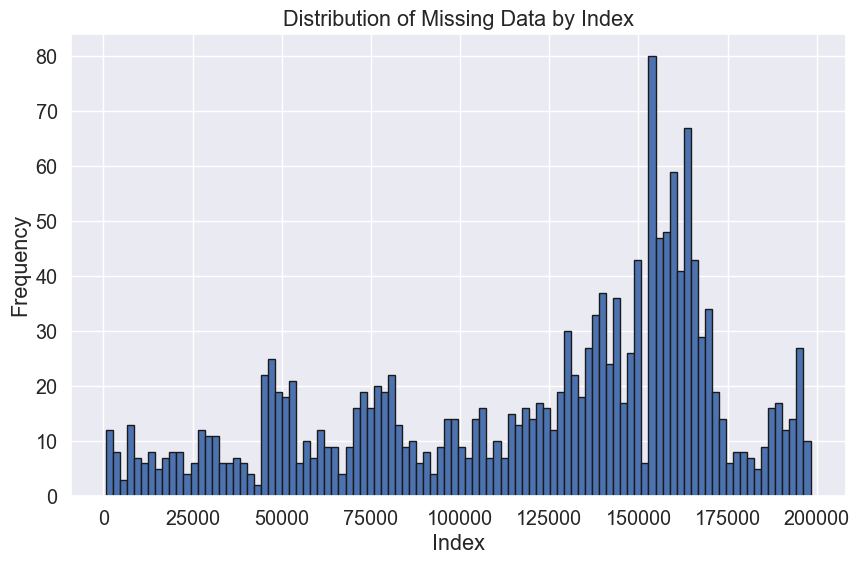

In [24]:
plt.figure(figsize=(10, 6))

indexes = empty_or_null_src.index

plt.hist(indexes, bins=100, edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Data by Index')
plt.show()

We can see there is a higher concentration of missing data towards the end of the file, between index 150 000 and index 170 000, signaling there might be a problem with the data in that region of the file. However, we cannot draw conclusions as it can be that missing data is more frequent for a certain year, and that this particular year is located in that region of the file, for instance.

Which is why we also need to plot the distribution of the missing data throughout the years.

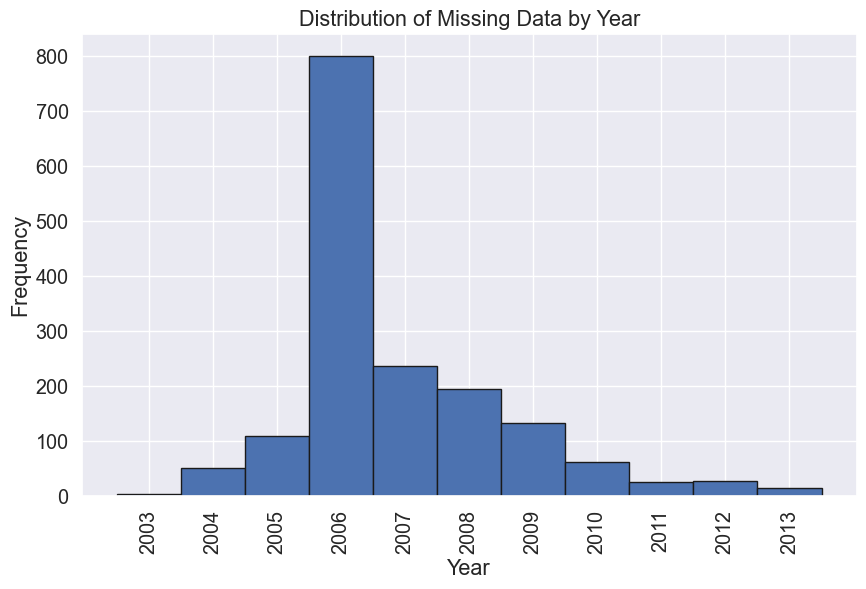

In [25]:
plt.figure(figsize=(10, 6))
yea_values = empty_or_null_src['YEA']
min_year = min(yea_values)
max_year = max(yea_values)
year_range = max_year - min_year + 1 

plt.hist(yea_values, bins=year_range, range=(min_year - 0.5, max_year + 0.5), edgecolor='k')
plt.xticks(range(min_year, max_year + 1), rotation=90)

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Data by Year')
plt.show()

We can see that the year 2006 has more missing values, however, this could simply be because that year has more data, and thus also more missing data. We need to check the percentage of missing data by year.

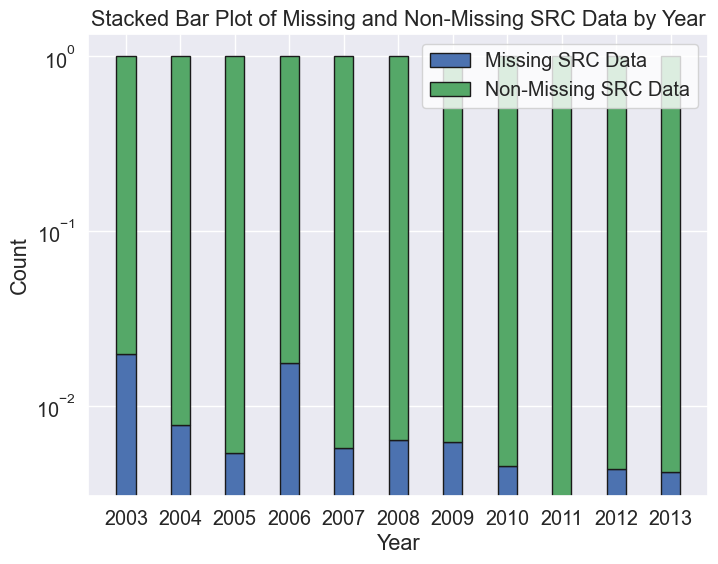

In [26]:
yearly_data_counts = wiki_df['YEA'].value_counts().sort_index()
missing_src_percentages = empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts
non_missing_src_percentages = non_empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts

fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
years = yearly_data_counts.index

plt.bar(years, missing_src_percentages, bar_width, label='Missing SRC Data', edgecolor='k')
plt.bar(years, non_missing_src_percentages, bar_width, label='Non-Missing SRC Data', edgecolor='k', bottom=missing_src_percentages)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Missing and Non-Missing SRC Data by Year')
plt.xticks(years)
plt.yscale('log')
plt.legend(frameon=True, facecolor="white")
plt.show()

We see that indeed there is more missing data for the years 2003 and 2006. Now, back to our initial hypothesis, which is that some part of the file might be corrupted, could it be, that for those years, a big part lies between the indexes where most of the missing data happens?

In [27]:
wiki_df.iloc[150000:170000]['YEA'].unique()

array([2006], dtype=int64)

We notice, that in those indexes, there is only votes corresponding to the year 2006, which might explain the number of missing data. <br>
In all cases, the fact that missing data happens in all years, seems to suggest that it isn't an error of parsing but simply a reality that comes with our dataset. <br>

Now, what do we do with this missing data?

First let's take a look at the amount of missing data

In [28]:
missing_src_percentages * 100

YEA
2003    1.970443
2004    0.779697
2005    0.538564
2006    1.765030
2007    0.570521
2008    0.639785
2009    0.622222
2010    0.450966
2011    0.303880
2012    0.432499
2013    0.419933
Name: count, dtype: float64

We have less than 1% of missing data for all the years except for the years 2003 and 2006 where we have less than 2%.

It appears that the missing data in this dataset may signify instances where users' accounts were potentially deleted or encountered other similar issues. While retaining their votes to justify election outcomes, the remaining data could have been discarded for GDPR compliance.
Because of this, we have decided to keep those votes when analysing the data.

## Grouping Elections <a id="group-elections"></a>

In order to analyse the elections' data, we need to draw a line between different elections. Fortunately, it seems that in our data file, the votes are ordered by election and by time, meaning, when a candidate changes in the data, that means that the vote is for a new election.

We use that information to identify different elections.

In [29]:
wiki_df['ELECTION_ID'] = 0
current_id = 1

for index, row in wiki_df.iterrows():
    tgt_value = row['TGT']
    
    if index > 0 and wiki_df.at[index - 1, 'TGT'] != tgt_value:
        current_id += 1  # Increment ELECTION_ID for a new 'TGT' value
    
    wiki_df.at[index, 'ELECTION_ID'] = current_id

In [30]:
display(wiki_df)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1
...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support,3926
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.,3927
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --,3927
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....,3927


We have given consecutive rows with the same "TGT" value the same ELECTION_ID value, however, we have not yet verified if there are instances where non-consecutive rows with the same "TGT" value belong to the same election.<br> To identify this, we will group by ELECTION_ID values and look at groups that have less than 5 voters, as this might signify that there is a problem with the grouping, we will then analyze some of these occurences to see if we can draw any conclusions from them.

In [31]:
grouped_elections = wiki_df.groupby('ELECTION_ID').size()
grouped_elections[grouped_elections <= 5]

ELECTION_ID
70      3
71      5
117     2
125     4
127     3
       ..
3924    5
3925    3
3926    3
3927    3
3928    1
Length: 335, dtype: int64

Let's take the election with id 70 and see why it has so little voters. We will look at the rows with that Election_ID, and then we will look at all rows with that election 'TGT' to see if we are missing some votes.

In [32]:
wiki_df[wiki_df['ELECTION_ID'] == 70]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


In [33]:
wiki_df[wiki_df['TGT'] == 'Baseballrocks538']

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


As we can see, it seems that the "Baseballrocks538" has indeed only received three votes, and that it doesn't come from a problem in our grouping.

Let's take an occurence where a same TGT corresponds to more than one ELECTION_ID, and analyse the different election groups.

In [34]:
unique_election_id_counts = wiki_df.groupby('TGT')['ELECTION_ID'].nunique()
unique_election_id_counts[unique_election_id_counts > 2]

TGT
Carnildo             3
Cobi                 3
Cool3                3
Curtis23             3
Elonka               3
Enigmaman            3
Everyking            6
Firefoxman           3
Footballfan190       3
Geni                 3
Guanaco              4
HJ Mitchell          3
Hex                  3
Ironholds            4
Juliancolton         3
Ktr101               4
Kww                  3
Leonard^Bloom        3
MONGO                3
MZMcBride            4
MoRsE                3
Porchcrop            3
Richardcavell        3
Robchurch            3
ST47                 3
Sceptre              3
Shoessss             3
Slon02               3
TenPoundHammer       3
The Transhumanist    4
Thumperward          3
Werdna               3
Wikiwoohoo           4
ZooPro               3
^demon               3
Name: ELECTION_ID, dtype: int64

Let's take the user 'Carnildo' for instance and look at the different election groups to which he belongs.

In [35]:
carnildo_df = wiki_df[(wiki_df['TGT'] == 'Carnildo')]
carnildo_df['ELECTION_ID'].unique()

array([2239, 2608, 3064], dtype=int64)

In [36]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2239].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
129888,UninvitedCompany,Carnildo,1,1,2006,2006-08-18 22:48:00,,2239
129889,Chacor,Carnildo,1,1,2006,2006-08-29 03:05:00,"This is bound to be a controversial RFA, but e...",2239
129890,crazytales56297,Carnildo,1,1,2006,2006-08-29 03:07:00,'''Support''' per Chacor. <!--begin crazytales...,2239
129891,Sean Black,Carnildo,1,1,2006,2006-08-29 03:09:00,--[[Special:Contributions/Sean Black|SB]] |,2239
129892,Mindspillage,Carnildo,1,1,2006,2006-08-29 03:20:00,'''Support'''. I believe the incident for whic...,2239


In [37]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2608].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
155749,Jahiegel,Carnildo,1,0,2006,2006-03-20 21:36:00,I've been waiting for Carnildo to accept and a...,2608
155750,RN,Carnildo,1,0,2006,2006-03-20 22:06:00,[[Image:Symbol support vote.svg|15px]] '''Supp...,2608
155751,BD2412,Carnildo,1,0,2006,2006-03-20 22:11:00,"''NEVER!!!'' Oh, wait, this is ''[[User:Carnil...",2608
155752,Rune.welsh,Carnildo,1,0,2006,2006-03-20 22:28:00,'''Strong support'''. His work regarding image...,2608
155753,Alhutch,Carnildo,1,0,2006,2006-03-20 22:43:00,'''Support''' per Rune. good user.--,2608


In [38]:
carnildo_df[carnildo_df['ELECTION_ID'] == 3064].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
173443,Redwolf24,Carnildo,1,1,2005,2005-08-13 01:34:00,"<font size=""+2"">SUPPORT!</font>",3064
173444,Starblind,Carnildo,1,1,2005,NaT,"'''Strong Support''' Excellent editor, strong ...",3064
173445,RN,Carnildo,1,1,2005,2005-08-13 03:57:00,'''Strong Support''' He can be a bit confrenta...,3064
173446,Denelson83,Carnildo,1,1,2005,2005-08-13 06:06:00,"'''Support!''' Support! Support! <span style=""...",3064
173447,Merovingian,Carnildo,1,1,2005,NaT,,3064


As we can see, the different ELECTION_ID correspond indeed to different elections.

We can also notice that a candidate can run for elections multiple times, even in the same year, which is why it is important to group elections in the order they appear in rather than taking the "YEA" column value for instance. Moreover, we notice that a candidate can run another time, even after winning an election, which is an odd occurence as adminship is supposed to be a definitive status, so how can it be that someone can run for adminship again, even after supposedly being elected the first time?

Let's see how many times that occur. We first group by elections, and then group by candidate, summing the results of the election. If the value is greater than 1, than means the candidate has won more than 1 election.

In [39]:
grouped_elections = wiki_df[['ELECTION_ID', 'RES', 'TGT']].drop_duplicates()
won_elections = grouped_elections.groupby('TGT')['RES'].sum()

In [40]:
print(f'Number of candidates having won more than one election: {len(won_elections[won_elections > 1])}\n')
display(won_elections[won_elections > 1])

Number of candidates having won more than one election: 18



TGT
Carnildo           2
Croat Canuck       2
Danny              2
Evercat            2
Everyking          2
Geni               2
Guanaco            2
HJ Mitchell        2
MZMcBride          2
Nev1               2
PMelvilleAustin    2
PeterSymonds       2
SarekOfVulcan      2
Sarge Baldy        2
Sean Black         2
Ugen64             2
W.marsh            2
^demon             2
Name: RES, dtype: int64

As we can see, there are 18 candidates who have one more than one election (precisely, two elections).

A quick look at Carnildo's history, shows us that he has been 'resysopped', meaning reelected (cf: https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_Signpost/2006-09-11/Carnildo_resysopped), which explains the fact that he has won two elections.

In fact, we find out that all the candidates in the list were reelected as well, as their names can be found in Wikipedia's list of resysopped users: https://en.wikipedia.org/wiki/Wikipedia:List_of_resysopped_users.

## Resulting Dataframes <a id="resulting-dataframes"></a>

Now that we have processed the data, we will create new dataframes containing statistics about the individuals and the elections that can be directly used when working with the data.

Let's start with the elections, we group the same elections and, as we did earlier, get the :
- Candidate
- Year
- Number of positive, neutral and negative votes.
- Percentage of positive, neutral and negative votes.
- Total number of votes
- Earliest and latest voting date.

For this, we define a function in the module `data_processing` that directly does the grouping and the aggregation.

In [41]:
elections_df = pd.merge(create_elections_df(wiki_df), wiki_df[['ELECTION_ID', 'YEA']].drop_duplicates(), on='ELECTION_ID', how='left')

In [44]:
elections_df.head(5)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00,2013
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00,2013
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00,2013
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00,2013
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00,2013


Now, we create a dataframe that contains the following information about candidates:
- The number of times they run for an election
- The number of times they won
- The number of times they lost
- The number of votes they received
- The percentage of positive votes they received
- The percentage of negative votes they received
- The percentage of neutral votes they received
- The average length of the comments they received

In [42]:
candidates_df = create_candidates_df(wiki_df)

In [43]:
candidates_df.head(10)

,USER,Number of Elections,Won Elections,Lost Elections,Votes Received,Positive Percentage,Negative Percentage,Neutral Percentage,Average Length Received
0,(aeropagitica),1,1,0,55,0.727273,0.181818,0.090909,106.672727
1,07bargem,1,0,1,6,0.000000,1.000000,0.000000,278.500000
2,1234r00t,1,0,1,6,0.000000,1.000000,0.000000,275.333333
3,168...,1,1,0,7,1.000000,0.000000,0.000000,42.000000
4,21655,1,0,1,24,0.166667,0.750000,0.083333,324.833333
5,23skidoo,1,1,0,58,1.000000,0.000000,0.000000,50.637931
6,28bytes,2,1,1,188,0.840426,0.132979,0.026596,217.938859
7,2over0,1,1,0,94,1.000000,0.000000,0.000000,106.765957
8,4836.03,1,0,1,26,0.076923,0.769231,0.153846,123.153846
9,5 albert square,1,1,0,104,0.971154,0.019231,0.009615,141.538462


Now, we create a dataframe that contains the following information about voters:
- The years they were active in
- The number of votes they cast
- The percentage of positive votes they cast
- The percentage of negative votes they cast
- The percentage of neutral votes they cast
- The percentage of times they voted similarly to the election result
- The percentage of times they voted differently than the election result
- The average length of the comments they cast

In [45]:
voters_df = create_voters_df(wiki_df)

In [46]:
voters_df.head(10)

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly,Average Length Cast
0,!---slappdash---!,[2009],1,100.000000,0.000000,0.000000,0.000000,100.000000,105.000000
1,%D0%90,[2006],13,100.000000,0.000000,0.000000,15.384615,84.615385,60.692308
2,'sed,[2006],3,100.000000,0.000000,0.000000,66.666667,33.333333,90.666667
3,(.Y.),[2006],1,100.000000,0.000000,0.000000,0.000000,100.000000,58.000000
4,(:Julien:),[2005],1,100.000000,0.000000,0.000000,0.000000,100.000000,98.000000
5,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765
6,*Kat*,"[2011, 2009, 2006]",5,80.000000,20.000000,0.000000,40.000000,60.000000,222.800000
7,*Spark*,[2006],1,100.000000,0.000000,0.000000,0.000000,100.000000,13.000000
8,*drew,"[2007, 2006, 2005]",29,75.862069,24.137931,0.000000,27.586207,72.413793,32.758621
9,-Midorihana-,"[2008, 2007]",75,84.000000,5.333333,10.666667,10.666667,89.333333,130.013333


## Load additional Datasets <a id="additional-datasets"></a>

Since our goal is to analyse the reasons motivating people's votes, we need metrics to evaluate the productivity of users. For this reason, we use additional datasets that contain statistics about Wikipedia users, namely: the number of pages they created, the number of articles they wrote, and the number of edits they made.

Those datasets are taken from the following Wikipedia articles:

Number of pages created: https://en.wikipedia.org/wiki/User:Bryan/List_of_users_by_pages_created <br>
Number of articles: https://en.wikipedia.org/wiki/Wikipedia:List_of_Wikipedians_by_article_count <br>
Number of edits: https://en.wikipedia.org/wiki/Wikipedia:List_of_Wikipedians_by_number_of_edits <br>

The extracted data files are in the `data` folder, while the functions used to parse and format them are in the `data_processing` module.

In [47]:
editors_df = parse_other_datasets(EDITORS_PATH)
authors_df = parse_other_datasets(AUTHORS_PATH)
creators_df = parse_other_datasets(CREATORS_PATH)

format_editors_df(editors_df)
format_authors_df(authors_df)
format_creators_df(creators_df)

The edits' dataset contains additional information about the category of users the user belong to.

- AC	Account creator <br>
- Ad	Administrator <br>
- AP	Autopatrolled <br>
- B	Bureaucrat <br>
- Ch	CheckUser <br>
- Co	Confirmed <br>
- ECo	Extended confirmed <br>
- EFH	Edit filter helper <br>
- EFM	Edit filter manager <br>
- EM	Extended mover <br>
- EvCo	Event coordinator <br>
- F	File mover <br>
- IM	Import <br>
- IAd	Interface administrator <br>
- IP	IPblock-exempt <br>
- MM	Mass message senders <br>
- N	New page reviewer <br>
- O	Oversighter <br>
- Ro	Rollbacker <br>
- Rs	Researcher <br>
- Rv	Pending changes reviewer <br>
- TE	Template editor <br>

In [48]:
display(editors_df)

,RANK,USER,NB_EDITS,CAT
0,1,Ser Amantio di Nicolao,5705768,"AP, Ad"
1,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE"
2,3,Jevansen,2408733,"AP, ECo, EM, Rv, Ro"
3,4,BD2412,2262281,"AP, IP, Ad"
4,5,Koavf,2153268,"AP, ECo, EM, F, N, Rv, Ro, TE"
...,...,...,...,...
9995,9996,Canis Lupus,11066,None
9996,9997,Shanel,11065,ECo
9997,9998,Cornellier,11064,"ECo, Rv"
9998,9999,Pink Fae,11064,"AP, ECo, Rv"


In [49]:
display(authors_df)

,RANK,USER,NB_ARTICLES
0,1,Yankees10,4821
1,1,Davidlofgren1996,4821
2,1,Kwamikagami,4821
3,1,Number 57,4821
4,1,Philafrenzy,4821
...,...,...,...
9996,9996,Kemkim,70
9997,9997,Karantsingh,70
9998,9998,Kaibabsquirrel,70
9999,9999,Jonyungk,70


In [50]:
display(creators_df)

,RANK,USER,NB_PAGES
0,1,Kotbot,55605
1,2,Dr. Blofeld,49089
2,3,Polbot,40174
3,4,Ram-Man,35076
4,5,AlbertHerring,14692
...,...,...,...
4995,4996,DavidCane,66
4996,4997,D Monack,66
4997,4998,Cwebb4,66
4998,4999,Colonies Chris,66


### Monthly editor activity dataset <a id="monhtly-edit-dataset"></a>

In addition to these three datasets, we also use a dataset giving a monthly wikimedia editor activity. This dataset provides detailed information for each (wiki, user, month) combination, including a count of all 'revisions' saved and a count of the revisions that were 'archived' during page deletions. The dataset can be accessed through the following link: https://data.world/wikimedia/monthly-wikimedia-editor-activity

Due to storage limitations, the initial dataset is too large for processing in this notebook. Instead, we store the preprocessed dataset, which is lighter.

The initial dataset comprises 42,198,710 rows and 8 columns, described as follows:

- wiki: The dbname of the wiki in question ("enwiki" for English Wikipedia, "commonswiki" for Commons)
- month: YYYYMM
- user_id: The user's identifier in the local wiki
- user_name: The user name in the local wiki (from the 'user' table)
- user_registration: The recorded registration date for the user in the 'user' table
- archived: The count of deleted revisions saved in this month by this user
- revisions: The count of all revisions saved in this month by this user (archived or not)
- attached_method: The method by which this user attached this account to their global account

As the initial dataset edits_df contains information about users who may not participate in the election process, we preprocess it to retain only the activities of interest: voters and candidates. Additionally, to align with the dataset specific to Wiki RfA that we are analyzing, we focus exclusively on edits made on the English Wikipedia (enwiki). We also exclude edits made after 2013, as then are not relevant for our study.

Certain columns, such as `user_id` and `attached_method`, are not relevant for our analysis and are therefore removed from the dataframe.<br>
While it would have been interesting to use the user_registration column to analyze the correlation between the longevity of voters or candidates and the election results, the dataset documentation indicates that the user registration date wasn't tracked correctly until 2006. Moreover, our exploration reveals that a single user can have multiple registration dates, making this column an inaccurate reflection of user longevity. Additionally, the column presents several missing values, further complicating analysis. To avoid potential misinterpretation of our results, we choose to remove this column.

For better comparison with the `DAT` column of wiki_df, we convert the `month` column to pandas datetime format, setting the date to the first day of the given month

In [179]:
edits_df = pd.read_csv("./data/wiki_editor_months.csv")

In [180]:
display(edits_df)

,month,user_name,archived,revisions
0,2001-02-01,Josh Grosse,2.0,20.0
1,2001-03-01,Jimbo Wales,0.0,14.0
2,2001-03-01,Malcolm Farmer,2.0,35.0
3,2001-03-01,Gareth Owen,1.0,16.0
4,2001-03-01,Josh Grosse,8.0,120.0
...,...,...,...,...
425970,2013-12-01,Nv8200p,0.0,137.0
425971,2013-12-01,Hyacinth,86.0,1403.0
425972,2013-12-01,Grendelkhan,0.0,2.0
425973,2013-12-01,Zero0000,0.0,229.0


In [84]:
print(f"Number of voters and candidates for which we have edits'activity : {edits_df['user_name'].nunique()} / {len(pd.concat([voters_df['USER'], candidates_df['USER']]).unique())}")

Number of voters and candidates for which we have edits'activity : 9983 / 11380


In [85]:
print(f"Number of voters for which we have edits'activity : {len(voters_df[voters_df['USER'].isin(edits_df['user_name'].unique())])} / {len(voters_df)}")

Number of voters for which we have edits'activity : 9264 / 10416


In [86]:
print(f"Number of candidates for which we have edits'activity : {len(candidates_df[candidates_df['USER'].isin(edits_df['user_name'].unique())])} / {len(candidates_df)}")

Number of candidates for which we have edits'activity : 3014 / 3497


## Data Exploration <a id="data-exploration"></a>

Let's now analyse various variables influencing the acceptance or rejection of candidates in elections, aiming to uncover the factors leading to a successful outcome.

We first start by doing a general data exploration to better understand the nature of our dataset and the conclusions we can draw from analysing it.

### General Data Exploration <a id="general-exploration"></a>

Let first take a look at the percentage of elections lost and won.

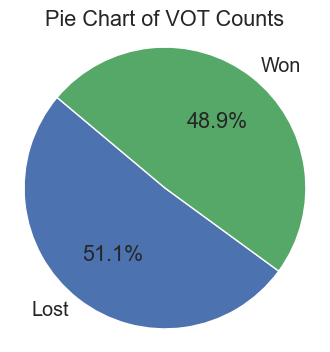

In [87]:
election_results_counts = elections_df['RES'].value_counts()

label_map = {1: 'Won', 0: 'Lost'}
election_labels = [label_map[val] for val in election_results_counts.index]

plt.figure(figsize=(4, 4))
plt.pie(election_results_counts, labels=election_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of VOT Counts')
plt.axis('equal')

plt.show()

In [88]:
print(f'Total Number of Elections: {len(elections_df)}')

Total Number of Elections: 3928


In [89]:
print(f'Number of unique voters : {len(voters_df)}')

Number of unique voters : 10416


In [90]:
print(f'Number of unique members (either voters or candidates) : {len(pd.concat([voters_df["USER"], candidates_df["USER"]]).unique())}')

Number of unique members (either voters or candidates) : 11380


#### Voters Exploration <a id="voters-exploration"></a>

Let's look at the evolution of the number of voters per year. 

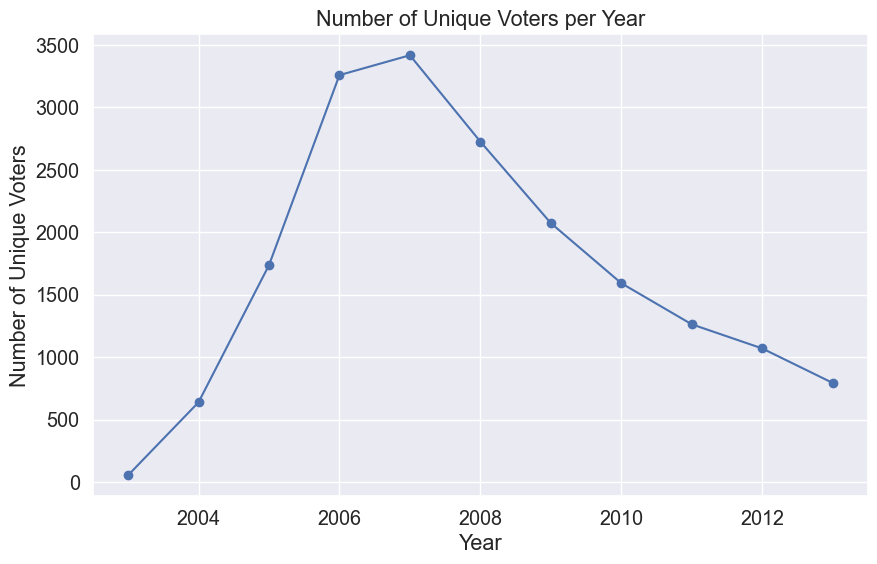

In [91]:
unique_voters_per_year = wiki_df.groupby(wiki_df['YEA'])['SRC'].nunique()

plt.figure(figsize=(10, 6))
plt.plot(unique_voters_per_year.index, unique_voters_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Voters')
plt.title('Number of Unique Voters per Year')
plt.grid(True)
plt.show()

In [92]:
print(f'Average number of unique voters per year: {unique_voters_per_year.mean(): 0.0f}')

Average number of unique voters per year:  1694


We can see that the number of voters peaks for the years 2006 and 2007 and then slowly decreases again, with an average of 1694 voters per year.

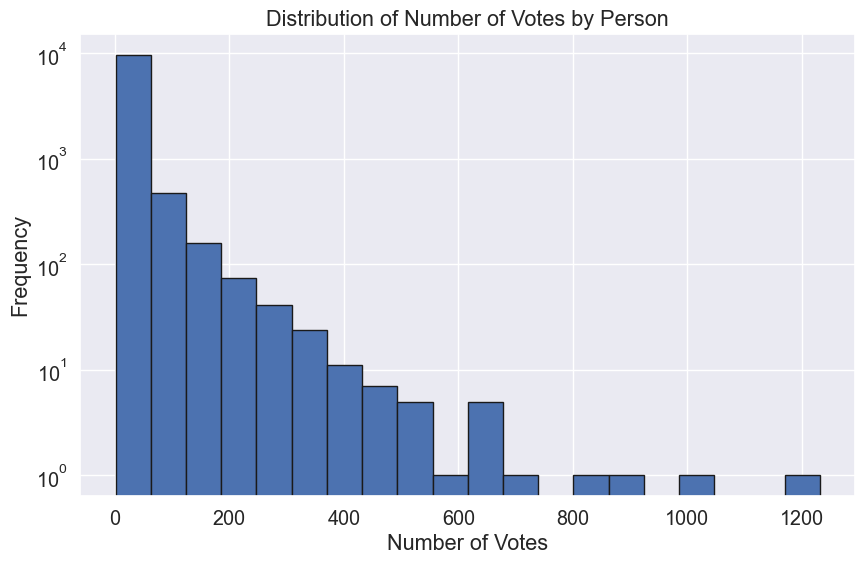

In [93]:
votes_distribution = voters_df['Votes Count']

plt.figure(figsize=(10, 6))
plt.hist(votes_distribution, bins=20, edgecolor='k')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Number of Votes by Person')
plt.show()

In [94]:
# Top voters
voters_df.nlargest(10, 'Votes Count')

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly,Average Length Cast
8222,Siva1979,"[2010, 2009, 2008, 2007, 2006]",1232,81.006494,14.285714,4.707792,39.285714,60.714286,149.906656
5571,Mailer diablo,"[2012, 2011, 2009, 2008, 2007, 2006, 2005]",998,79.659319,11.823647,8.517034,23.647295,76.352705,35.943888
5865,Merovingian,"[2009, 2008, 2007, 2006, 2005, 2004]",916,86.026201,5.895197,8.078603,22.707424,77.292576,21.573144
9874,Wizardman,"[2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006]",810,77.160494,18.148148,4.691358,38.888889,61.111111,104.849383
223,Acalamari,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",726,96.694215,2.341598,0.964187,27.134986,72.865014,183.603306
9968,Xoloz,"[2008, 2007, 2006, 2005]",677,46.085672,51.698671,2.215657,59.231905,40.768095,162.568685
6925,Pedro,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",663,69.834087,21.870287,8.295626,42.081448,57.918552,392.788839
2517,Dlohcierekim,"[2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006]",661,76.399395,17.700454,5.900151,41.754917,58.245083,233.453858
1003,Bearian,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",635,80.000000,8.188976,11.811024,27.086614,72.913386,156.757480
8571,Stifle,"[2013, 2011, 2010, 2009, 2008, 2007, 2006]",628,53.662420,32.484076,13.853503,49.203822,50.796178,83.853503


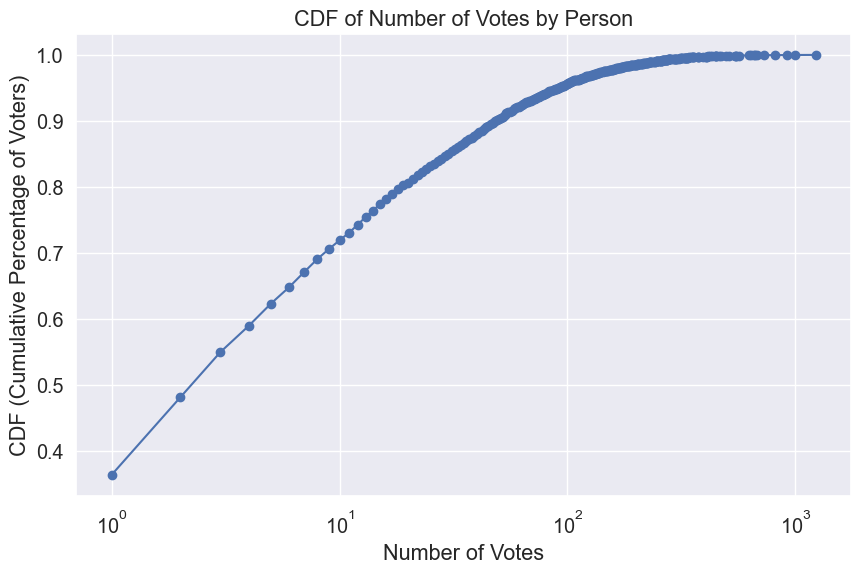

In [95]:
cdf = votes_distribution.value_counts().sort_index().cumsum() / len(votes_distribution) 

plt.figure(figsize=(10, 6))
plt.plot(cdf.index, cdf, marker='o', linestyle='-')
plt.xlabel('Number of Votes')
plt.ylabel('CDF (Cumulative Percentage of Voters)')
plt.title('CDF of Number of Votes by Person')
plt.xscale('log')
plt.grid(True)
plt.show()

In [96]:
print(f'Median of number of votes per voter: {votes_distribution.value_counts().sort_index().median()}')
print(f'Mean of number of votes per voter: {votes_distribution.value_counts().sort_index().mean()}')

Median of number of votes per voter: 3.0
Mean of number of votes per voter: 34.15081967213115


Looking at the CDF plot of the number of votes per person, we notice that half of the voters have voted less than 3 times, and 36% of the voters have only voted one time. <br>
The median of the number of votes per voter is 3 while the mean is 34, potentially signifying that our distribution is skewed to the right.

Let's analyse similarity of voters between each pair of years, this will allow us to see if the nature of voters change throughout the years.

In [97]:
voters_active_years = voters_df['Active Years']
unique_years = wiki_df['YEA'].unique()

results_df = pd.DataFrame(index=unique_years, columns=unique_years).astype(float)


In [98]:
# We go through pairs of years and extract the percentage of similar voters, we add them to a resulting dataframe
for y1 in unique_years:
    for y2 in unique_years:
        if y1 == y2:
            results_df.at[y1, y2] = 1
        else:
            results_df.at[y1, y2] = len(voters_active_years[voters_active_years.apply(lambda x: y1 in x and y2 in x)].index) / len(voters_active_years[voters_active_years.apply(lambda x: y1 in x)])


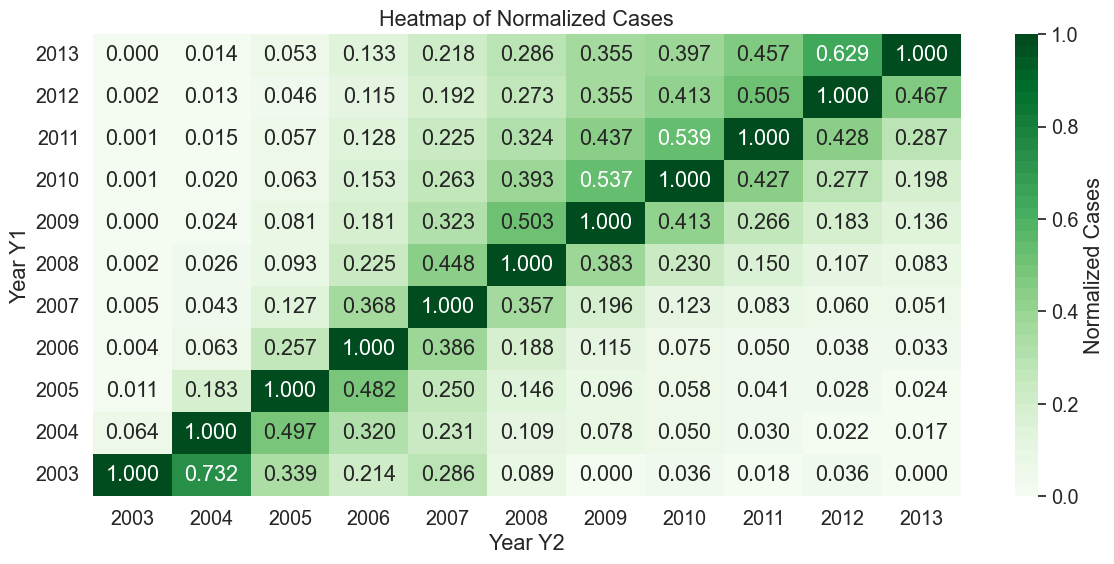

In [99]:
results_df = results_df.reindex(sorted(results_df.columns), axis=1)

plt.figure(figsize=(14, 6))
sns.heatmap(results_df, cmap=sns.color_palette("Greens", 40), annot=True, fmt=".3f", cbar_kws={'label': 'Normalized Cases'})

plt.xlabel('Year Y2')
plt.ylabel('Year Y1')
plt.title('Heatmap of Normalized Cases')

plt.show()

The heatmap reads like this : for a given pair of years ${y}_{i}, y_{j}$, the value in row $i$ and column $j$ is the percentage of voters in year $i$ that have also voted in year $j$.


The heatmap shows us that there is a lot of variability in the voters, and there aren't as many voters that are common between years as one would assume. However, this makes sense considering more than 50\% of voters have voted less than 4 times.

We can see higher values around the diagonal which shows the amount of common voters between close years, as the years drift apart, the number of common voters tend to reduce.

Such a vizualisation is important to see the correlation between the identities of voters between years. For instance, if we were ever to analyze text used in 2003 and compare it to the text used in 2013, we must be aware that there are no common voters between the two years, the analysis might thus reveal differences not because the language has changed, but rather because there are different voters using different language.

But so far, we have considered the number of votes per year, and not per election. So, let's now observe the trend of the average number of votes per election over the years.

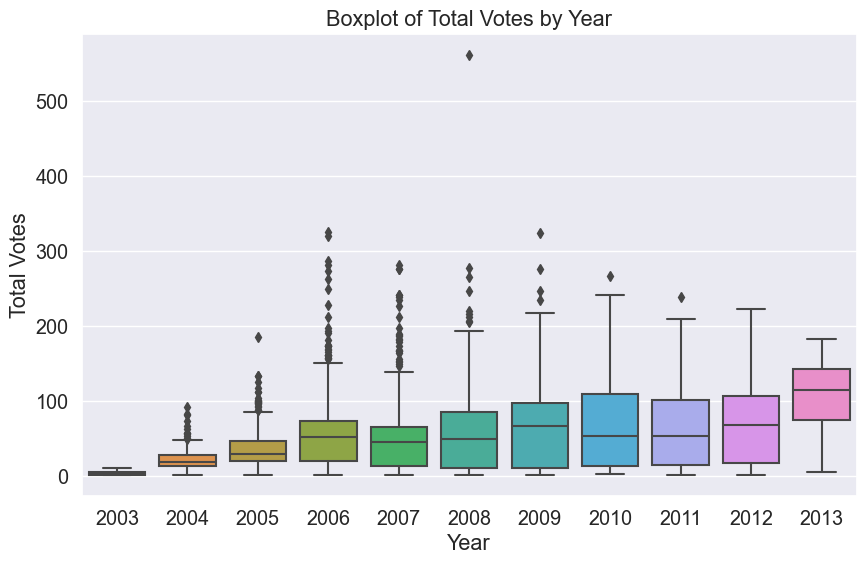

In [103]:
plt.figure(figsize=(10, 6))

# Create a boxplot for each year
sns.boxplot(x='YEA', y='Total Votes', data=elections_df)

plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.title('Boxplot of Total Votes by Year')

plt.show()

We can see that all election do not generate the same interest in the Wikipedia community, voter interest varies significantly across elections. In fact, excluding the year 2013, which has the lowest number of elections recorded in our dataset and is not the most representative, 25% of the elections in a given year have fewer than 20 voters participating. Some elections even have only one voter.

#### Candidates Exploration <a id="candidate-exploration"></a>

We will now proceed with the same data exploration, but for candidates.

In [104]:
print(f'Number of unique candidates : {len(candidates_df["USER"])}')

Number of unique candidates : 3497


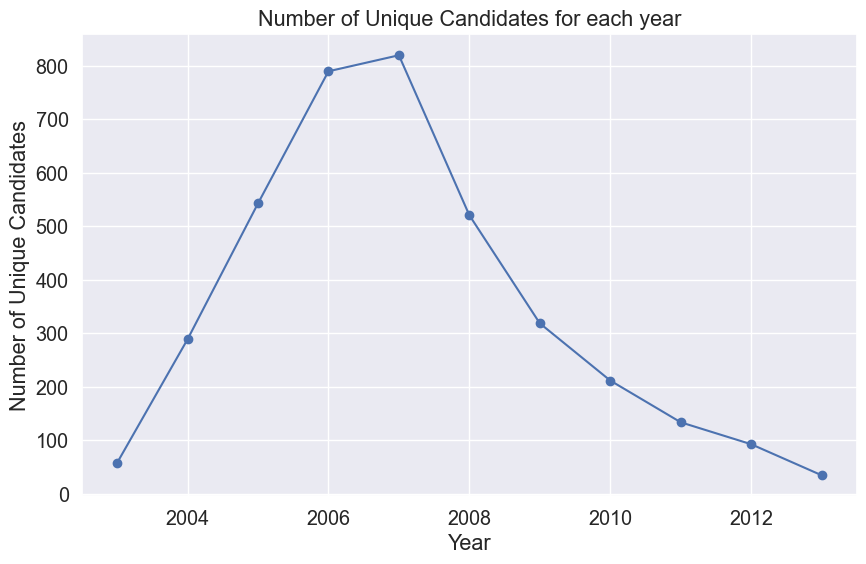

In [106]:
unique_candidates_per_year = wiki_df.groupby(wiki_df['YEA'])['TGT'].nunique()

plt.figure(figsize=(10, 6))
plt.plot(unique_candidates_per_year.index, unique_candidates_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Candidates')
plt.title('Number of Unique Candidates for each year')
plt.grid(True)
plt.show()

We can see that there are significant variations in the number of candidates for Wikipedia Adminship throughout the years. In particular, there is a peak for the years 2006 and 2007. This could be explained by the expansion and ever-growing popularity of Wikipedia during those years. However, between 2008 and 2012, the number of candidates seems to be exponentially decreasing.

#### Election Analysis <a id="election-analysis"></a>

Now that we have successfully identified distinct elections, let's look at some statistics about the elections.

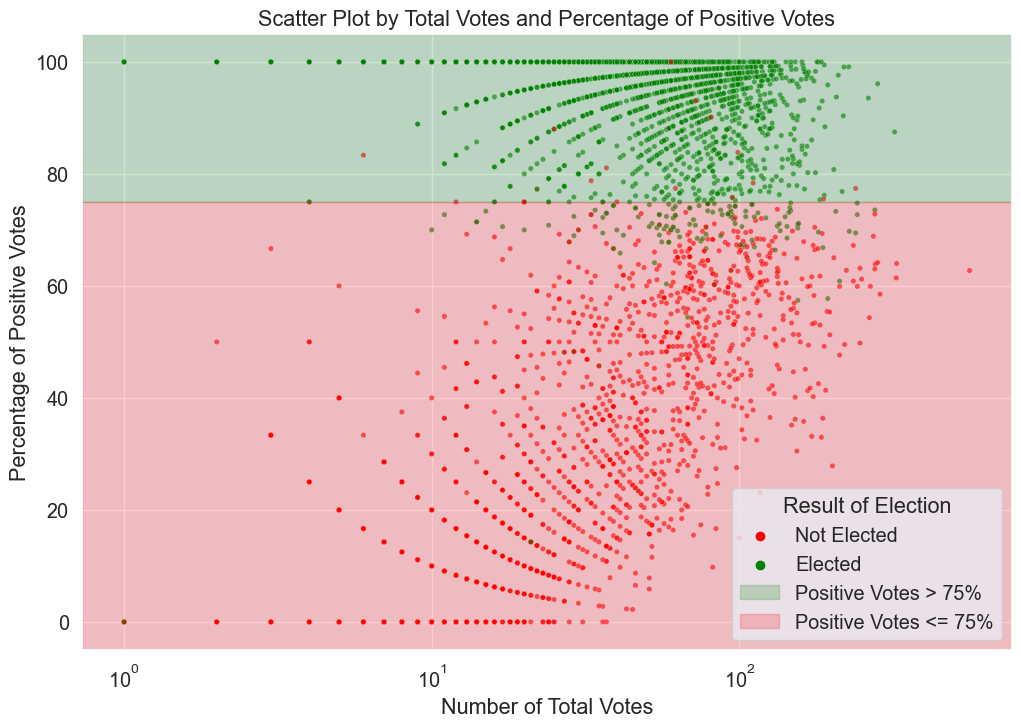

In [107]:
# Assuming 'total_votes', 'positive_percentage', and 'RES' are the columns in elections_df
plt.figure(figsize=(12, 8))

# Scatter plot with points colored by the percentage of positive votes
scatter = sns.scatterplot(x='Total Votes', y='Positive Percentage', hue='RES', data=elections_df, palette={0: 'red', 1: 'green'}, s=15, alpha=0.6)

plt.axhspan(75, 105, color='green', alpha=0.2, label='Positive Votes > 75%')
plt.axhspan(-5, 75, color='red', alpha=0.2, label='Positive Votes <= 75%')

plt.title('Scatter Plot by Total Votes and Percentage of Positive Votes')
plt.xlabel('Number of Total Votes')
plt.ylabel('Percentage of Positive Votes')
plt.ylim(-5, 105)
plt.xscale('log')
plt.legend(title='Result of Election', loc='upper right', labels=['Not Elected', 'Elected'])

# Adjust the legend
handles, labels = scatter.get_legend_handles_labels()
labels[0] = 'Not Elected'
labels[1] = 'Elected'
scatter.legend(handles, labels, title='Result of Election', loc='lower right')

plt.show()

The wikipedia article about RfA elections states : "Consensus at RfA is not determined by surpassing a numerical threshold, but by the strength of rationales presented. In practice, most RfAs above $75\%$ support pass." (https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship).

The treshold is indeed noticeable, however, the plot shows that it is a bit below $75\%$. We can also notice that there are some exceptions that have a very high positive votes percentage, yet end up not being elected, and vice-versa. Which echoes the fact that a certain percentage of votes is not a guarantee of a successful election. However, the opposite seems to be true, indeed, for the vast majority of cases, it seems that having less than $50\%$ of positive votes is a guarantee of failing the election.


But RfA is not a straightforward majority vote, there is no precise "pass" or "fail" percentage, the $75\%$ is only given as an approximate guide and it is the job of bureaucrats to determine the concensus results of a request for admniship.


Indeed, there are even cases where candidates were rejected even if 100% of the votes they received were positives. Let's dig deeper into them.

In [108]:
elections_df[(elections_df['Positive Percentage'] == 100) & (elections_df['RES'] == 0)]

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA
1193,1194,matt037291,0,1,1,0,0,100.0,0.0,0.0,2008-12-22 11:06:00,2008-12-22 11:06:00,2008
2003,2004,Moralis,0,1,1,0,0,100.0,0.0,0.0,2007-04-13 14:31:00,2007-04-13 14:31:00,2007
2787,2788,LtPowers,0,1,1,0,0,100.0,0.0,0.0,2006-08-12 17:24:00,2006-08-12 17:24:00,2006
2793,2794,madcowpoo,0,14,14,0,0,100.0,0.0,0.0,2006-10-02 19:42:00,2006-10-02 21:26:00,2006
2950,2951,The Fish,0,13,13,0,0,100.0,0.0,0.0,2006-02-05 18:46:00,2006-02-08 23:27:00,2006
2988,2989,Weyes3,0,1,1,0,0,100.0,0.0,0.0,2006-03-14 09:52:00,2006-03-14 09:52:00,2006
3478,3479,Ilmari Karonen,0,1,1,0,0,100.0,0.0,0.0,2005-11-23 08:50:00,2005-11-23 08:50:00,2005
3483,3484,"Just zis Guy, you know?",0,1,1,0,0,100.0,0.0,0.0,2005-11-05 10:14:00,2005-11-05 10:14:00,2005
3494,3495,MarkGallagher,0,2,2,0,0,100.0,0.0,0.0,2005-10-28 15:48:00,2005-10-28 15:53:00,2005
3526,3527,Robchurch,0,60,60,0,0,100.0,0.0,0.0,2005-10-10 00:21:00,2005-10-16 23:57:00,2005


After conducting research on Wikipedia websites, specifically https://en.wikipedia.org/wiki/Wikipedia:Unsuccessful_adminship_candidacies/ + [first-letter-of-candidate], it becomes clear that, for the majority of these elections (with exceptions of `Moralis` and `Robchurch`), either the candidate refused the nomination, or the election was withdrawn by a bureaucrat who deemed the candidate unprepared. Thus, the margin remains at 1.0 due to the sudden end of the election but the recorded outcome is unsuccessful.

In the case of the candidate `Moralis`, the election followed a new experimental format of the RfA, which was not captured in this dataset.

The scenario involving the candidate `Robchurch` is particular. There were two distinct outcomes, initially negative and subsequently positive, for the same election. Unfortunately, the reasons for this dual outcome remain obscure.

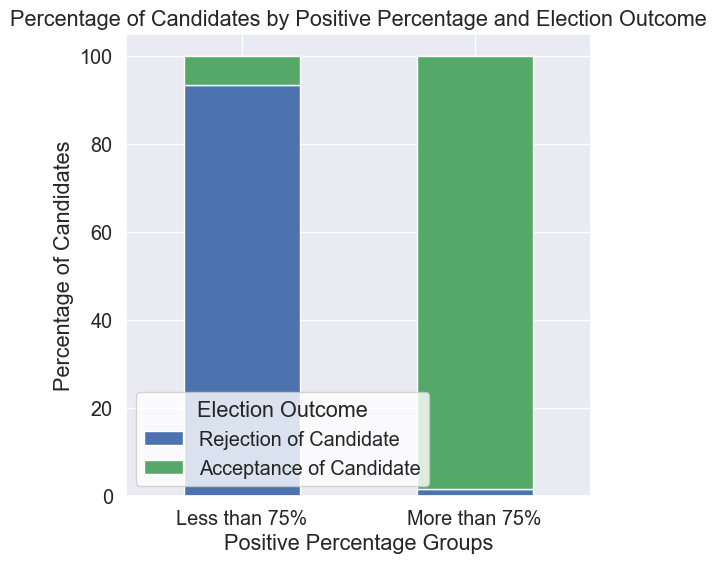

In [109]:
margin_df = elections_df.groupby(elections_df['Positive Percentage'].ge(75).map({True: 'More than 75%', False: 'Less than 75%'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = margin_df.plot(kind='bar', stacked=True, figsize=(6, 6))

plt.xlabel('Positive Percentage Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by Positive Percentage and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
plt.xticks(rotation=0)

plt.show()

In [110]:
margin_df

RES,0,1
Positive Percentage,,
Less than 75%,93.339632,6.660368
More than 75%,1.656543,98.343457


In summary, aspiring administrators should target a positive margin, as only $6.66\%$ of candidates who don't exceed the indicative threshold of $75\%$ positive votes are elected successfully.

Let's look closer at the distribution of the percentage of positive votes in won elections and the percentage of negative votes in lost elections

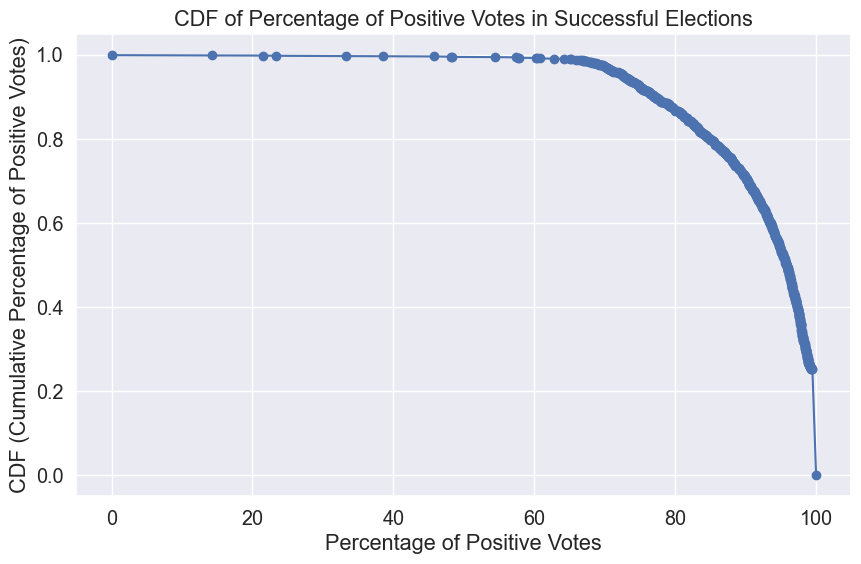

In [111]:
won_elections_distribution = elections_df[elections_df['RES'] == 1]['Positive Percentage']
ccdf = 1 - won_elections_distribution.value_counts().sort_index().cumsum() / len(won_elections_distribution) 

plt.figure(figsize=(10, 6))
plt.plot(ccdf.index, ccdf, marker='o', linestyle='-')
plt.xlabel('Percentage of Positive Votes')
plt.ylabel('CDF (Cumulative Percentage of Positive Votes)')
plt.title('CDF of Percentage of Positive Votes in Successful Elections')
plt.grid(True)
plt.show()

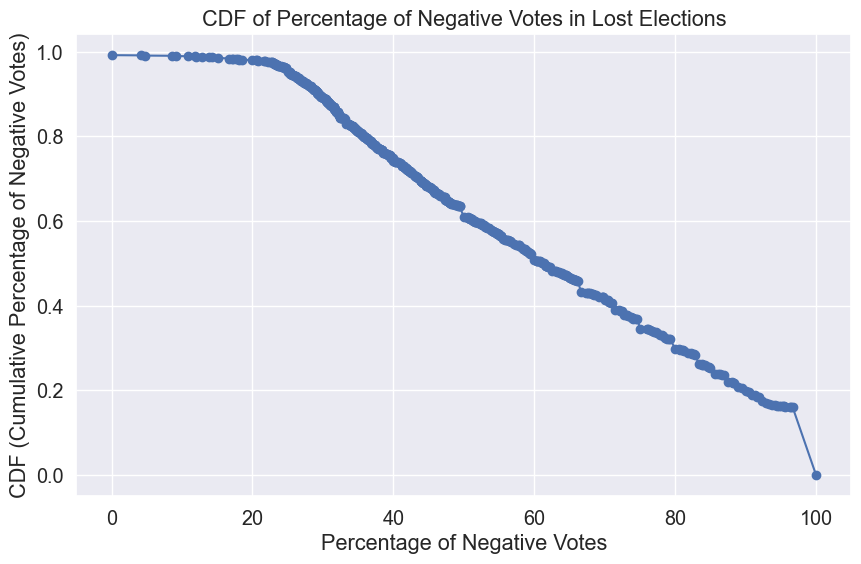

In [112]:
lost_elections_distribution = elections_df[elections_df['RES'] == 0]['Negative Percentage']
ccdf = 1 - lost_elections_distribution.value_counts().sort_index().cumsum() / len(lost_elections_distribution) 

plt.figure(figsize=(10, 6))
plt.plot(ccdf.index, ccdf, marker='o', linestyle='-')
plt.xlabel('Percentage of Negative Votes')
plt.ylabel('CDF (Cumulative Percentage of Negative Votes)')
plt.title('CDF of Percentage of Negative Votes in Lost Elections')
plt.grid(True)
plt.show()

We notice that 80% of won elections have gathered more than 80% of positive votes, while 80% of lost elections had more than 30% of negative votes. This tells us that positive votes are important for the success of an election, but negative votes are not the only reasons a candidate might lose, this highlights the importance of positive votes. Indeed, a candidate might lose not because they have too many negative votes, but rather because they do not have enough positive ones. Hence the pivotal role neutral votes can play, and the importance of understanding why people vote positively, in order to convert the neutral votes into positive ones and change the outcome of an election. In the following section, we will exxplore the influence neutral votes may have on election outcome

### Influence of the total number of votes <a id="influence-total-votes"></a>

Let's first take a look at the distribution of the total number of votes in an election in our dataset across won and lost elections.

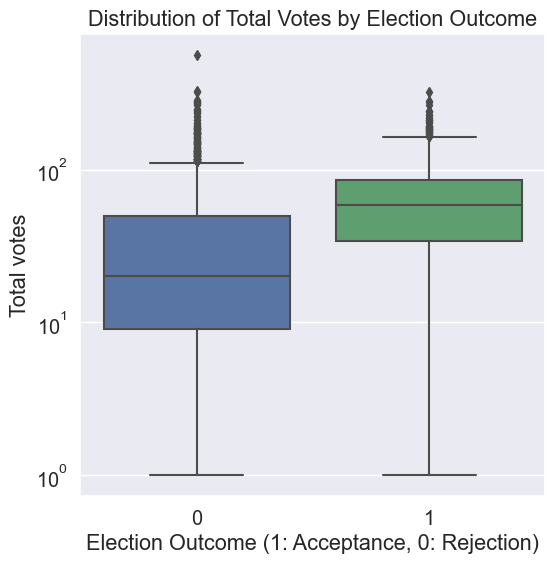

In [113]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='RES', y='Total Votes', data=elections_df)
plt.xlabel('Election Outcome (1: Acceptance, 0: Rejection)')
plt.ylabel('Total votes')
plt.title('Distribution of Total Votes by Election Outcome')
plt.yscale('log')
plt.show()

Observing the boxplot, we notice difference in the distribution of total votes between successful and unsuccessful elections. The median for unsuccessful elections is around $20\%$, while for successful elections, it is $59\%$. This indicates a tendency for unsuccessful elections to have a lower number of total votes.

Let's conduct a statistical test to evaluate the significancy of the difference between the distribution of the total number of votes across successful and unsucessful elections.

In [114]:
accepted_total = elections_df[elections_df['RES'] == 1]['Total Votes']
rejected_total = elections_df[elections_df['RES'] == 0]['Total Votes']

t_stat, p_value = ttest_ind(accepted_total, rejected_total, alternative='greater')
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 19.433487005681993
P-value: 1.0754187199116965e-80


With an extremely low p-value of $1.07e-80$, we can confidently reject the null hypothesis. The observed results suggests that the total number of votes may play a role in election outcomes.

But, let's investigate this more in depth by considering the covariates like the positive, negative and neutral percentage of votes. For this, we consider a binary variable stating if the election had an above average total number of votes.

In [115]:
threshold_low_nbvotes = elections_df['Total Votes'].mean()

print("Mean value of total number of votes per election : ", threshold_low_nbvotes)

Mean value of total number of votes per election :  50.47734215885947


In [116]:
elections_df['HighNumberOfVotes'] = (elections_df['Total Votes'] > threshold_low_nbvotes).astype(int)
display(elections_df)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,HighNumberOfVotes
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00,2013,1
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00,2013,1
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00,2013,1
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00,2013,1
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,5,5,0,0,100.000000,0.000000,0.000000,2003-10-09 04:54:00,2003-11-09 19:16:00,2003,0
3924,3925,Ugen64,1,3,3,0,0,100.000000,0.000000,0.000000,2003-12-06 16:05:00,2003-12-06 16:05:00,2003,0
3925,3926,Vancouverguy,1,3,3,0,0,100.000000,0.000000,0.000000,2003-08-31 02:13:00,2003-09-02 02:51:00,2003,0
3926,3927,WhisperToMe,1,3,3,0,0,100.000000,0.000000,0.000000,2003-11-26 23:45:00,2003-12-05 05:38:00,2003,0


Now, we perform a one-to-one matching using the propensity score defined by the covariates we discussed, considering the condition of having an above-average number of votes as the treatment. This will allow us to assess the true effect of the total number of votes on the outcome of the election.

In [117]:
psm = PsmPy(elections_df, treatment='HighNumberOfVotes', indx='ELECTION_ID', exclude = ['TGT','RES', 'Total Votes', 'Negative Votes', 'Neutral Votes', 'Positive Votes', 
                                                                                            'Neutral Percentage', 'Earliest Voting Date', 'Latest Voting Date', 'YEA'])

psm.logistic_ps(balance = True)

psm.knn_matched(matcher='propensity_score', replacement=False, caliper=None, drop_unmatched=True)

elections_df_balanced_total = psm.df_matched

C:\Users\User\anaconda3\envs\ada\lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


In [118]:
elections_df_balanced_total = elections_df[elections_df['ELECTION_ID'].isin(elections_df_balanced_total['ELECTION_ID'])]

In [119]:
display(elections_df_balanced_total)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,HighNumberOfVotes
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00,2013,1
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00,2013,1
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00,2013,1
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00,2013,1
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,5,5,0,0,100.000000,0.000000,0.000000,2003-10-09 04:54:00,2003-11-09 19:16:00,2003,0
3924,3925,Ugen64,1,3,3,0,0,100.000000,0.000000,0.000000,2003-12-06 16:05:00,2003-12-06 16:05:00,2003,0
3925,3926,Vancouverguy,1,3,3,0,0,100.000000,0.000000,0.000000,2003-08-31 02:13:00,2003-09-02 02:51:00,2003,0
3926,3927,WhisperToMe,1,3,3,0,0,100.000000,0.000000,0.000000,2003-11-26 23:45:00,2003-12-05 05:38:00,2003,0


C:\Users\User\AppData\Local\Temp\ipykernel_14276\2837637664.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\2837637664.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


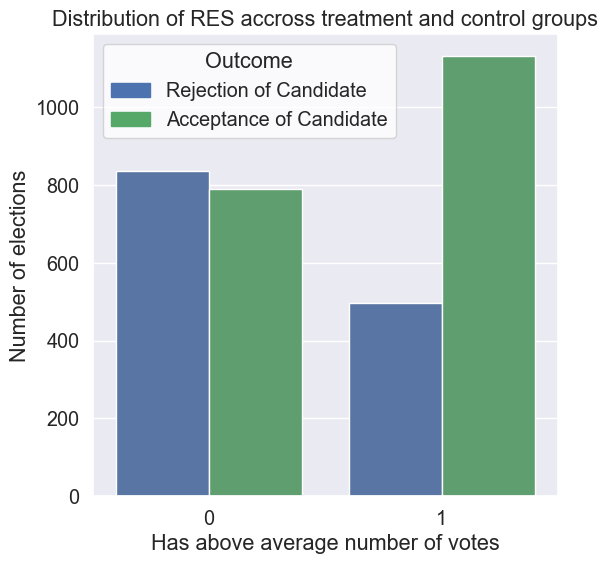

In [122]:
plt.figure(figsize=(6, 6))

sns.countplot(x='HighNumberOfVotes', hue='RES', data=elections_df_balanced_total)

plt.xlabel('Has above average number of votes')
plt.ylabel('Number of elections')
plt.title('Distribution of RES accross treatment and control groups')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

Examining the plot, it suggests that elections with an above-average number of voters tend to have a higher success rate.  This could be partly explained by the fact that Wikipedia bureaucrats have the right to promptly close an election if they think the candidate is unprepared or if the election is going poorly, as stated in the Wikipedia guide: https://en.wikipedia.org/wiki/Wikipedia:Guide_to_requests_for_adminship#Closure

To validate this observation, we conduct a chi-square testtest. Our null hypothesis, denoted as $H_0$, states that there is no association between having an above-average number of votes in an election and the election outcome.

In [121]:
contingency_table = pd.crosstab(index=elections_df_balanced_total['HighNumberOfVotes'], columns=elections_df_balanced_total['RES'])

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")

Chi-Square Value: 146.32437390336756
P-value: 1.1026271966342159e-33


Since the p-value is extremely small, the result suggests that elections with an above-average number of votes are significantly different in terms of outcomes compared to elections with under-average number of votes. But what about the differences within each group of elections? Is there an equal chance of being elected or not if the candidate has a number of votes below the $50$ average? Is there a significantly higher chance of being elected than being rejected if the candidate gets more than $50$ votes?

In [123]:
candidates_with_high_nbvotes = elections_df_balanced_total[elections_df_balanced_total['HighNumberOfVotes'] == 1]

accepted_candidates = candidates_with_high_nbvotes[candidates_with_high_nbvotes['RES'] == 1].shape[0]
rejected_candidates = candidates_with_high_nbvotes[candidates_with_high_nbvotes['RES'] == 0].shape[0]

total_candidates = len(candidates_with_high_nbvotes)

stat, p_value = proportions_ztest(accepted_candidates, total_candidates, value=0.5, alternative='larger')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The probabilities of being accepted and rejected within the group of candidates with high number of votes are significantly different.")
else:
    print("There is no significant difference in the probabilities of being accepted and rejected within the group of candidates with high number of votes.")

Z-statistic: 17.0599
P-value: 0.0000
The probabilities of being accepted and rejected within the group of candidates with high number of votes are significantly different.


In [124]:
candidates_with_high_nbvotes = elections_df_balanced_total[elections_df_balanced_total['HighNumberOfVotes'] == 0]

accepted_candidates = candidates_with_high_nbvotes[candidates_with_high_nbvotes['RES'] == 1].shape[0]
rejected_candidates = candidates_with_high_nbvotes[candidates_with_high_nbvotes['RES'] == 0].shape[0]

total_candidates = len(candidates_with_high_nbvotes)

stat, p_value = proportions_ztest(accepted_candidates, total_candidates, value=0.5, alternative='two-sided')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The probabilities of being accepted and rejected within the group of candidates with low number of votes are significantly different.")
else:
    print("There is no significant difference in the probabilities of being accepted and rejected within the group of candidates with low number of votes.")

Z-statistic: -1.1657
P-value: 0.2437
There is no significant difference in the probabilities of being accepted and rejected within the group of candidates with low number of votes.


The results above show that for the control group, the chance of being elected is roughly the same as the one of being rejected, while there is an increased probability of being elected for candidates who have high number of votes. 

Let's now quantify the influence of the total number of votes with a regression.

In [125]:
mod = smf.ols(formula='RES ~ C(HighNumberOfVotes)', data=elections_df_balanced_total)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    RES   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     154.1
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           1.35e-34
Time:                        20:36:15   Log-Likelihood:                -2233.3
No. Observations:                3255   AIC:                             4471.
Df Residuals:                    3253   BIC:                             4483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

After balancing the data in terms of positive percentage and negative percentage, the regression analysis suggests that elections with above-average number of votes have, on average, a higher chance of being successful compared to elections with under-average number of votes. Specifically, the mean chance of being elected is $48.5\%$ when the number of votes is below the average ($50$ votes) while it is $69.4\%$ for election with a high number of voters.

### Influence of the Neutral Votes <a id="influence-neutral-votes"></a>

First, let's look at the distribution of the votes in our dataset.

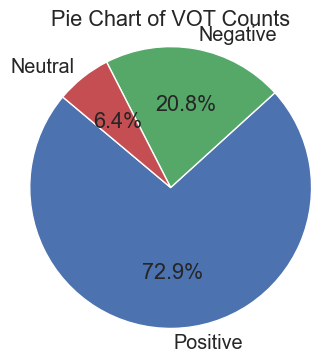

In [126]:
vote_counts = wiki_df['VOT'].value_counts()

label_map = {1: 'Positive', 0: 'Neutral', -1: 'Negative'}
vote_labels = [label_map[val] for val in vote_counts.index]

plt.figure(figsize=(4, 4))
plt.pie(vote_counts, labels=vote_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of VOT Counts')
plt.axis('equal') 

plt.show()

We can see that neutral votes represent $6.4\%$ of our total votes. This percentage might seem with little influence, but let's dig deeper about how it could affect the election outcome

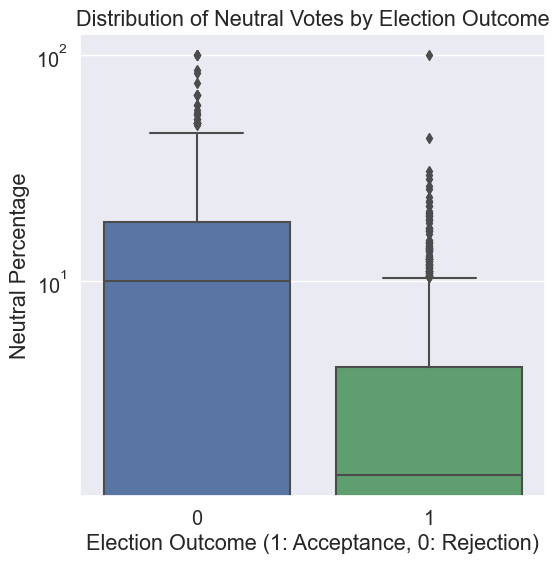

In [132]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='RES', y='Neutral Percentage', data=elections_df)
plt.xlabel('Election Outcome (1: Acceptance, 0: Rejection)')
plt.ylabel('Neutral Percentage')
plt.title('Distribution of Neutral Votes by Election Outcome')
plt.yscale('log')
plt.show()

Observing the boxplot, we notice a notable difference in the distribution of neutral votes between successful and unsuccessful elections. The median for unsuccessful elections is around $10\%$, while for successful elections, it is approximately $1\%$. This indicates a tendency for unsuccessful elections to have a higher proportion of neutral votes.
To confirm this observation, we will conduct a statistical test.

In [128]:
accepted_neutral = elections_df[elections_df['RES'] == 1]['Neutral Percentage']
rejected_neutral = elections_df[elections_df['RES'] == 0]['Neutral Percentage']

t_stat, p_value = ttest_ind(accepted_neutral, rejected_neutral, alternative='less')
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -31.779310313423153
P-value: 9.773620097370759e-198


The t-test results reveal a significant difference in the proportion of neutral votes between accepted and rejected candidates. With an extremely low p-value of $9.77e-198$, we can confidently reject the null hypothesis. The observed results suggests that the neutrality of votes may play a role in election outcomes.

This motivates our project, indeed, by analysing the motives behind voting, we could possibly be able to change neutral votes into positive ones, changing the outcome of an election.

C:\Users\User\AppData\Local\Temp\ipykernel_14276\1231508314.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\1231508314.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


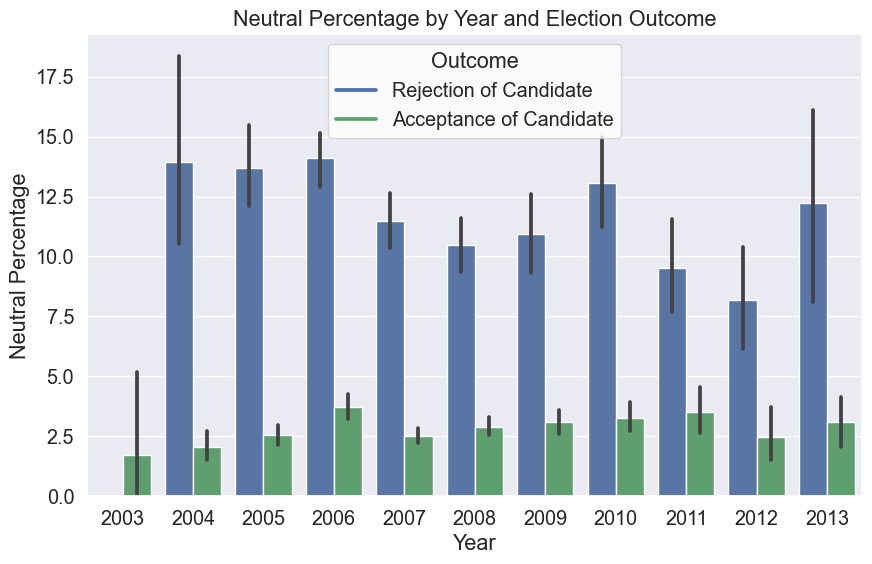

In [129]:
plt.figure(figsize=(10, 6))

sns.barplot(x='YEA', y='Neutral Percentage', hue='RES', data=elections_df)

plt.xlabel('Year')
plt.ylabel('Neutral Percentage')
plt.title('Neutral Percentage by Year and Election Outcome')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

We notice that this holds true for all years and that there no drastic differences between years.

However, we cannot conclude the analysis here, as the outcome depends on various factors, and the current analysis doesn’t allow to isolate the effect of the percentage of neutral votes.  Let's perform an exact one-to-one matching considering the total number of votes and the percentage of positive votes as covariates. Each election with no neutral votes (“treated group”) is matched to an election with at least one neutral vote (“control group”).

In [130]:
elections_df['HighNeutralPercentage'] = (elections_df['Neutral Percentage'] != 0).astype(int)

In [131]:
psm = PsmPy(elections_df, treatment='HighNeutralPercentage', indx='ELECTION_ID', exclude = ['TGT','RES', 'Negative Votes', 'Neutral Votes', 'Positive Votes',
                                                                                       'Negative Percentage', 'Neutral Percentage', 'Earliest Voting Date',
                                                                                       'Latest Voting Date', 'YEA', 'HighNumberOfVotes'])

psm.logistic_ps(balance = True)
psm.knn_matched(matcher='propensity_score', replacement=False, caliper=None, drop_unmatched=True)
elections_df_balanced_neutral = psm.df_matched

In [134]:
elections_df_balanced_neutral = elections_df[elections_df['ELECTION_ID'].isin(elections_df_balanced_neutral['ELECTION_ID'])]
display(elections_df_balanced_neutral)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,HighNumberOfVotes,HighNeutralPercentage
12,13,Paulmcdonald,1,100,89,8,3,89.000000,8.000000,3.000000,2013-04-30 22:43:00,2013-05-08 10:05:00,2013,1,1
16,17,Tokyogirl79,1,148,146,2,0,98.648649,1.351351,0.000000,2013-03-11 08:48:00,2013-03-18 08:19:00,2013,1,0
18,19,Ymblanter,1,126,124,2,0,98.412698,1.587302,0.000000,2013-03-15 08:04:00,2013-03-22 04:28:00,2013,1,0
19,20,angelo1345,0,9,2,7,0,22.222222,77.777778,0.000000,2013-04-09 12:29:00,2013-04-09 13:26:00,2013,0,0
20,21,AppleJack-7,0,11,0,9,2,0.000000,81.818182,18.181818,2013-06-03 02:57:00,2013-06-03 05:37:00,2013,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,5,5,0,0,100.000000,0.000000,0.000000,2003-10-09 04:54:00,2003-11-09 19:16:00,2003,0,0
3924,3925,Ugen64,1,3,3,0,0,100.000000,0.000000,0.000000,2003-12-06 16:05:00,2003-12-06 16:05:00,2003,0,0
3925,3926,Vancouverguy,1,3,3,0,0,100.000000,0.000000,0.000000,2003-08-31 02:13:00,2003-09-02 02:51:00,2003,0,0
3926,3927,WhisperToMe,1,3,3,0,0,100.000000,0.000000,0.000000,2003-11-26 23:45:00,2003-12-05 05:38:00,2003,0,0


C:\Users\User\AppData\Local\Temp\ipykernel_14276\11924210.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\11924210.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


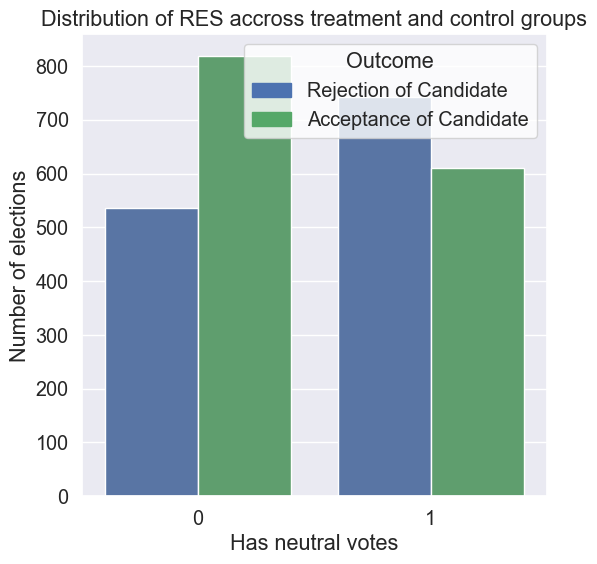

In [135]:
plt.figure(figsize=(6, 6))

sns.countplot(x='HighNeutralPercentage', hue='RES', data=elections_df_balanced_neutral)

plt.xlabel('Has neutral votes')
plt.ylabel('Number of elections')
plt.title('Distribution of RES accross treatment and control groups')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

The observed plot provides indication that elections with at least one neutral vote tend to have a higher frequency of unsuccessful outcomes. To rigorously investigate and quantify this association, a statistical approach is employed. The null hypothesis ($H_0$) posits that there is no discernible link between the presence of neutral votes, indicated by a neutral percentage greater than zero, and the election outcome.

To test the validity of this hypothesis, a chi-square test is conducted. 

In [136]:
chi2, p, _, _ = chi2_contingency(pd.crosstab(index=elections_df_balanced_neutral['HighNeutralPercentage'], columns=elections_df_balanced_neutral['RES']))

In [137]:
print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")

Chi-Square Value: 63.53447153509291
P-value: 1.5758494520978883e-15


Since the p-value is extremely small, this implies that elections where candidates receive at least some neutral votes exhibit a distinct pattern in terms of success or failure compared to those without any neutral votes. 

Let's quantify the influence of the fact of receiving at least one neutral vote with a regression.

In [111]:
mod = smf.ols(formula='RES ~ C(HighNeutralPercentage)', data=elections_df_balanced_neutral)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    RES   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     65.66
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           8.03e-16
Time:                        12:21:12   Log-Likelihood:                -1927.4
No. Observations:                2706   AIC:                             3859.
Df Residuals:                    2704   BIC:                             3871.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

After balancing the data in terms of positive percentage and total votes, the regression analysis suggests that candidates who receive neutral votes have, on average, a lower chance of being elected compared to elections without neutral votes. Specifically, the mean chance of being elected drops from $60\%$ to $45\%$ when there are neutral votes present.

### General Analysis of Additional Datasets <a id="additional"></a>

Although not timestamped, additional datasets can inform us on whether there are any correlations between the activity of a user and its status: elected or not. For now, we take a general overview of those statistics without taking into consideration the activity before election or after election.

In [7]:
DATA_PATH = './data/top_creators.txt'

with open(DATA_PATH, 'r', encoding='utf-8') as data_file:
    lines = data_file.readlines()

data_lines = [line.strip() for line in lines if not line.startswith('|-')]
data_lines = [line[2:] for line in data_lines]

data_dict = defaultdict(list)

for i in range(3, len(data_lines), 3):
    data_dict[data_lines[0]].append(data_lines[i])
    data_dict[data_lines[1]].append(data_lines[i+1])
    data_dict[data_lines[2]].append(data_lines[i+2])

creators_df = pd.DataFrame(data_dict)
creators_df['USER'] = creators_df.apply(lambda row: row['USER'].split('|')[1] if '|' in row['USER'] else row['USER'], axis=1)
creators_df['USER'] = creators_df['USER'].str.rstrip("]]")

creators_df['NB_PAGES'] = creators_df['NB_PAGES'].astype(int)

#### Creators Data <a id="creators"></a>

In [7]:
DATA_PATH = './data/top_creators.txt'

with open(DATA_PATH, 'r', encoding='utf-8') as data_file:
    lines = data_file.readlines()

data_lines = [line.strip() for line in lines if not line.startswith('|-')]
data_lines = [line[2:] for line in data_lines]

data_dict = defaultdict(list)

for i in range(3, len(data_lines), 3):
    data_dict[data_lines[0]].append(data_lines[i])
    data_dict[data_lines[1]].append(data_lines[i+1])
    data_dict[data_lines[2]].append(data_lines[i+2])

creators_df = pd.DataFrame(data_dict)
creators_df['USER'] = creators_df.apply(lambda row: row['USER'].split('|')[1] if '|' in row['USER'] else row['USER'], axis=1)
creators_df['USER'] = creators_df['USER'].str.rstrip("]]")

creators_df['NB_PAGES'] = creators_df['NB_PAGES'].astype(int)

In [8]:
creators_df.head(5)

,RANK,USER,NB_PAGES
0,1,Kotbot,55605
1,2,Dr. Blofeld,49089
2,3,Polbot,40174
3,4,Ram-Man,35076
4,5,AlbertHerring,14692


Let's incorporate the information we have regarding the number of pages created into our wiki dataset.

In [9]:
merged_df = pd.merge(creators_df, wiki_copy, left_on='USER', right_on='TGT', how='inner')

In [10]:
merged_df.head(5)

,RANK,USER,NB_PAGES,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,5,AlbertHerring,14692,Maximillion Pegasus,AlbertHerring,1,0,2008,NaT,'''Support''' I would like to see a little mor...,1021,Support I would like to see a little more Wiki...
1,5,AlbertHerring,14692,Basketball110,AlbertHerring,1,0,2008,NaT,'''Support''' as nom (shouldn't I be first to ...,1021,Support as nom (shouldn't I be first to suppor...
2,5,AlbertHerring,14692,Wisdom89,AlbertHerring,-1,0,2008,NaT,'''Oppose''' - I essentially knew how I was go...,1021,Oppose - I essentially knew how I was going to...
3,5,AlbertHerring,14692,Alanbly,AlbertHerring,-1,0,2008,NaT,'''Oppose''' - Proportionately miniscule use o...,1021,Oppose - Proportionately miniscule use of talk...
4,5,AlbertHerring,14692,Siva1979,AlbertHerring,-1,0,2008,NaT,'''Oppose''' per the above comments. --<font s...,1021,Oppose per the above comments.


Let's see how many candidates we have information about the number of pages created.

In [11]:
unique_candidate_df = wiki_copy.drop_duplicates(subset='TGT', keep='first')
unique_common_candidate_df = merged_df.drop_duplicates(subset='USER', keep='first')
print(f"Percentage of the wiki dataset explain by the creators dataset {round(100*len(unique_common_candidate_df)/len(unique_candidate_df),2)} %")

Percentage of the wiki dataset explain by the creators dataset 27.11 %


Now, we can create a box plot representing the distribution of the number of pages created based on the election result.

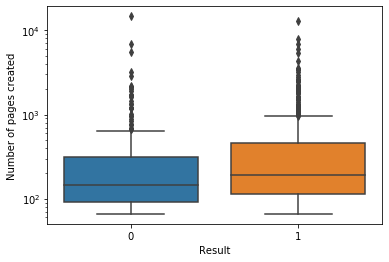

In [12]:
res_nb_pages = unique_common_candidate_df[['NB_PAGES','RES']]
plot = sns.boxplot(x="RES", y="NB_PAGES", data=res_nb_pages)
plt.xlabel("Result")
plt.ylabel("Number of pages created")
plt.yscale('log')

We can conduct a t-test to determine if there is a significant difference between the means of the rejected and accepted groups.

In [13]:
rejected = res_nb_pages[res_nb_pages['RES'] == 0]['NB_PAGES']
accepted = res_nb_pages[res_nb_pages['RES'] == 1]['NB_PAGES']

t_statistic, p_value = ttest_ind(rejected, accepted)

print(f'P-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference.")
else:
    print("There is no significant difference.")

P-value: 0.7588801182901398
There is no significant difference.


As indicated by the t-test, there is no significant difference. Therefore, we cannot conclude that creating more pages leads to a better chance of being elected.

Let's extract the editors dataset

In [14]:
DATA_PATH = './data/top_editors.txt'

with open(DATA_PATH, 'r', encoding='utf-8') as data_file:
    lines = data_file.readlines()

data_lines = [line.strip() for line in lines if not line.startswith('|-')]
data_lines = [line[2:] for line in data_lines]

data_dict = defaultdict(list)

data_lines.insert(4003, 'NaN') # missing data correction

for i in range(4, len(data_lines), 4):
    data_dict[data_lines[0]].append(data_lines[i])
    data_dict[data_lines[1]].append(data_lines[i+1])
    data_dict[data_lines[2]].append(data_lines[i+2])
    data_dict[data_lines[3]].append(data_lines[i+3])


editors_df = pd.DataFrame(data_dict)
editors_df['USER'] = editors_df.apply(lambda row: row['USER'].split('|')[1] if '|' in row['USER'] else row['USER'], axis=1)
editors_df['USER'] = editors_df['USER'].str.rstrip("]]")

editors_df['NB_EDITS'] = editors_df['NB_EDITS'].apply(lambda x: str(x).replace(",", ""))
editors_df['NB_EDITS'] = editors_df['NB_EDITS'].astype(int)

In [15]:
editors_df.head(5)

,RANK,USER,NB_EDITS,CAT
0,1,Ser Amantio di Nicolao,5705768,"AP, Ad"
1,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE"
2,3,Jevansen,2408733,"AP, ECo, EM, Rv, Ro"
3,4,BD2412,2262281,"AP, IP, Ad"
4,5,Koavf,2153268,"AP, ECo, EM, F, N, Rv, Ro, TE"


Let's incorporate the information we have regarding the number of edits made into our wiki dataset.

In [16]:
common_candidate_df = pd.merge(editors_df, wiki_copy, left_on='USER', right_on='TGT', how='inner')

In [17]:
common_candidate_df.head(5)

,RANK,USER,NB_EDITS,CAT,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE",D-Day,BrownHairedGirl,1,1,2006,NaT,'''Support on WHEELS!!!''' Looks good to me! -...,2231,Support on WHEELS!!! Looks good to me! (
1,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE",Rama's Arrow,BrownHairedGirl,1,1,2006,NaT,'''Support''' I find nothing wrong in self-nom...,2231,Support I find nothing wrong in self-nominatin...
2,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE",Tone,BrownHairedGirl,1,1,2006,NaT,'''Support'''. Looks good to me also. --'''[[U...,2231,Support. Looks good to me also.
3,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE",Lethe,BrownHairedGirl,1,1,2006,NaT,'''Support'''. I am a person who's not too ke...,2231,Support. I am a person who's not too keen on ...
4,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE",Nephron,BrownHairedGirl,1,1,2006,NaT,'''Support'''. Looks alright. No sign that the...,2231,Support. Looks alright. No sign that they woul...


Let's see how many candidates we have information about the number of edits made.

In [18]:
unique_candidate_df = wiki_copy.drop_duplicates(subset='TGT', keep='first')
unique_common_candidate_df = common_candidate_df.drop_duplicates(subset='USER', keep='first')
print(f"Percentage of the wiki dataset explain by the editors dataset {round(100*len(unique_common_candidate_df)/len(unique_candidate_df),2)} %")

Percentage of the wiki dataset explain by the editors dataset 44.07 %


Now, we can create a box plot representing the distribution of the number of edits made based on the election result.

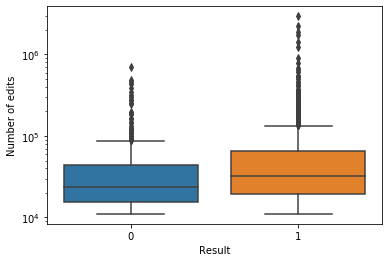

In [19]:
res_nb_edits = unique_common_candidate_df[['NB_EDITS','RES']]
plot = sns.boxplot(x="RES", y="NB_EDITS", data=res_nb_edits)
plt.xlabel("Result")
plt.ylabel("Number of edits")
plt.yscale('log')

We can conduct a t-test to determine if there is a significant difference between the means of the rejected and accepted groups.

In [20]:
rejected = res_nb_edits[res_nb_edits['RES'] == 0]['NB_EDITS']
accepted = res_nb_edits[res_nb_edits['RES'] == 1]['NB_EDITS']

t_statistic, p_value = ttest_ind(rejected, accepted)

print(f'P-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference.")
else:
    print("There is no significant difference.")

P-value: 0.021456774615374565
There is a significant difference.


As we can see, there is a significant difference, so we can conclude that making edits increases the chance of being elected.

#### Authors data <a id="authors"></a>

Let's extract the authors dataset

In [21]:
DATA_PATH = './data/top_authors.txt'

with open(DATA_PATH, 'r', encoding='utf-8') as data_file:
    lines = data_file.readlines()

data_lines = [line.strip() for line in lines if not line.startswith('|-')]
data_lines = [line[2:] for line in data_lines]

data_dict = defaultdict(list)

for i in range(3, len(data_lines), 3):
    data_dict[data_lines[0]].append(data_lines[i])
    data_dict[data_lines[1]].append(data_lines[i+1])
    data_dict[data_lines[2]].append(data_lines[i+2])

authors_df = pd.DataFrame(data_dict)
authors_df['USER'] = authors_df.apply(lambda row: row['USER'].split('|')[1] if '|' in row['USER'] else row['USER'], axis=1)
authors_df['USER'] = authors_df['USER'].str.rstrip("]]")

authors_df['NB_ARTICLES'] = authors_df.apply(lambda row: row['NB_ARTICLES'].split('|')[1] if '|' in row['NB_ARTICLES'] else row['NB_ARTICLES'], axis=1)
authors_df['NB_ARTICLES'] = authors_df['NB_ARTICLES'].str.rstrip("]}}")
authors_df['NB_ARTICLES'] = authors_df['NB_ARTICLES'].str.lstrip("[")

authors_df['RANK'] = authors_df['RANK'].apply(lambda x: str(x).replace("Top 100 Random Sort", "1"))
authors_df['NB_ARTICLES'] = authors_df['NB_ARTICLES'].apply(lambda x: str(x).replace("count protected", "4821"))
authors_df['NB_ARTICLES'] = authors_df['NB_ARTICLES'].apply(lambda x: str(x).replace(",", ""))
authors_df['NB_ARTICLES'] = authors_df['NB_ARTICLES'].astype(int)

In [22]:
authors_df.head(5)

,RANK,USER,NB_ARTICLES
0,1,Yankees10,4821
1,1,Davidlofgren1996,4821
2,1,Kwamikagami,4821
3,1,Number 57,4821
4,1,Philafrenzy,4821


Let's incorporate the information we have regarding the number of articles created into our wiki dataset.

In [23]:
merged_df = pd.merge(authors_df, wiki_copy, left_on='USER', right_on='TGT', how='inner')

In [24]:
merged_df.head(5)

,RANK,USER,NB_ARTICLES,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,1,Kwamikagami,4821,The Singing Badger,Kwamikagami,1,1,2005,NaT,,3209,
1,1,Kwamikagami,4821,Astrotrain,Kwamikagami,1,1,2005,NaT,Support,3209,Support
2,1,Kwamikagami,4821,Private Butcher,Kwamikagami,1,1,2005,NaT,"'''Support''', enough edits, and has been here...",3209,"Support, enough edits, and has been here for a..."
3,1,Kwamikagami,4821,JonMoore,Kwamikagami,1,1,2005,NaT,"'''Support'''. Kwamikagami is a great editor, ...",3209,"Support. Kwamikagami is a great editor, and th..."
4,1,Kwamikagami,4821,Ish ishwar,Kwamikagami,1,1,2005,NaT,"'''support''' - good phonetics, phonology, ext...",3209,"support - good phonetics, phonology, extra."


Let's see how many candidates we have information about the number of articles created.

In [25]:
unique_candidate_df = wiki_copy.drop_duplicates(subset='TGT', keep='first')
unique_common_candidate_df = merged_df.drop_duplicates(subset='USER', keep='first')
print(f"Percentage of the wiki dataset explain by the editors dataset {round(100*len(unique_common_candidate_df)/len(unique_candidate_df),2)} %")

Percentage of the wiki dataset explain by the editors dataset 29.6 %


Now, we can create a box plot representing the distribution of the number of articles created based on the election result.

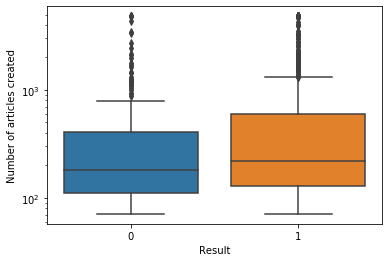

In [26]:
res_nb_articles = unique_common_candidate_df[['NB_ARTICLES','RES']]
plot = sns.boxplot(x="RES", y="NB_ARTICLES", data=res_nb_articles)
plt.xlabel("Result")
plt.ylabel("Number of articles created")
plt.yscale('log')

We can conduct a t-test to determine if there is a significant difference between the means of the rejected and accepted groups.

In [27]:
rejected = res_nb_articles[res_nb_articles['RES'] == 0]['NB_ARTICLES']
accepted = res_nb_articles[res_nb_articles['RES'] == 1]['NB_ARTICLES']

t_statistic, p_value = ttest_ind(rejected, accepted)

print(f'P-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference.")
else:
    print("There is no significant difference.")

P-value: 0.20299662389187162
There is no significant difference.


As indicated by the t-test, there is no significant difference. Therefore, we cannot conclude that creating more articles leads to a better chance of being elected.

#### Similarity in Voting

In this section, we explore whether there are any differences between users who tend to vote similarly to the result of the election or those who vote in a different way. We're trying to understand if that has any influence on the result of elections: do users who vote with the majority have a higher chance of winning?

For this, we use the additional dataset voters_df we created.

We merge this dataframe with the wiki dataset to apply a T-test later and determine if there is a correlation between the similarity of the votes and the election outcome.

In [87]:
voters_wiki_df = pd.merge(voters_df, wiki_df, left_on='USER', right_on='TGT', how='inner')
voters_wiki_df.head(10)

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly,Average Length Cast,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Dbiv,(aeropagitica),1,1,2006,NaT,"'''Support'''. Yippee, I get to be the first!",2192,"Support. Yippee, I get to be the first!"
1,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,King of Hearts,(aeropagitica),1,1,2006,NaT,"'''Support''' as nominator, of course. --",2192,"Support as nominator, of course."
2,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Blnguyen,(aeropagitica),1,1,2006,NaT,"'''Support''' have seen this chap around, help...",2192,"Support have seen this chap around, helping on..."
3,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Zsinj,(aeropagitica),1,1,2006,NaT,"'''Support''', even though the majority of edi...",2192,"Support, even though the majority of edits are..."
4,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Kuru,(aeropagitica),1,1,2006,NaT,"'''Support''', edits on AfD are ''contribution...",2192,"Support, edits on AfD are contributions rather..."
5,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Waggers,(aeropagitica),1,1,2006,NaT,'''Support'''. I've said it before and I'll s...,2192,Support. I've said it before and I'll say it ...
6,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Johnleemk,(aeropagitica),1,1,2006,NaT,Weak '''support'''; would prefer more article ...,2192,Weak support; would prefer more article and us...
7,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Siva1979,(aeropagitica),1,1,2006,NaT,"'''Support''' per Johnleemk. --<font style=""ba...",2192,Support per Johnleemk.
8,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Essexmutant,(aeropagitica),1,1,2006,NaT,"'''Support''', meets my standards. No reason t...",2192,"Support, meets my standards. No reason to oppose."
9,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765,Stifle,(aeropagitica),1,1,2006,NaT,"'''Support''', I don't see why not.",2192,"Support, I don't see why not."


Let's create a bar plot to visualize the difference.

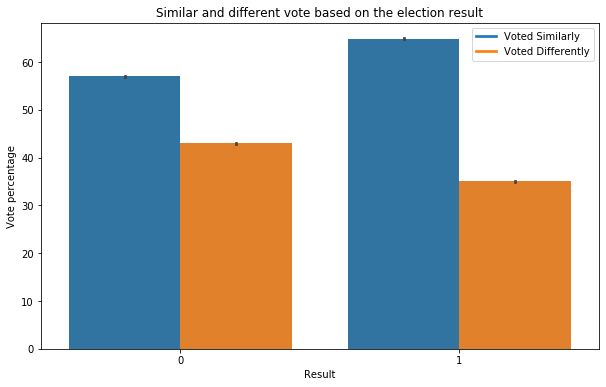

In [90]:
plt.figure(figsize=(10, 6))

melted_voters_wiki_df = pd.melt(voters_wiki_df, id_vars=['RES'], value_vars=['Voted Similarly', 'Voted Differently'],
                    var_name='Vote Type', value_name='Count')

sns.barplot(x='RES', y='Count', hue='Vote Type', data=melted_voters_wiki_df)

plt.xlabel('Result')
plt.ylabel('Vote percentage')
plt.title('Similar and different vote based on the election result')

legend = plt.legend(labels=['Voted Similarly', 'Voted Differently'])
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

When people vote similarly to the outcome of the election, it appears that they are more likely to get elected later on. We can conduct a T-test to determine if the difference is significant.

In [92]:
rejected = voters_wiki_df[voters_wiki_df['RES'] == 0]['Voted Similarly']
accepted = voters_wiki_df[voters_wiki_df['RES'] == 1]['Voted Similarly']

t_statistic, p_value = ttest_ind(rejected, accepted)

print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference")
else:
    print("There is no significant difference")

P-value: 0.0
There is a significant difference


We can conclude that voting in alignment with the majority can increase our chances of getting elected.

In reality, all those results indicate an important aspect that we did not take into account and which may explain some of our results being non concluding, that is, that we do not take into account activity prior to the moment of the election. If we were to do that, we would need a timestamped dataset. This will be the subject of our next section.

### Influence of previous activity before running for adminship <a id="influence-previous-activity"></a>

For each candidate, we investigate the votes they cast before the start date of their election. We gather information on the total number of positive, negative, and neutral votes the candidate made, along with the average length of the comments they provided. We also use the edits dataset to collect the number of revisions a candidate made before running for adminship.

In [138]:
def summarize_before_adminship(row):
    election_id = row['ELECTION_ID']
    candidate = row['TGT']
    start_date = row['Earliest Voting Date']
    res = row['RES']
    
    candidate_votes_before = wiki_df[(wiki_df['SRC'] == candidate) & (wiki_df['DAT'] < start_date)]
                                
    num_votes_no = (candidate_votes_before['VOT'] == -1).sum()
    num_votes_yes = (candidate_votes_before['VOT'] == 1).sum()
    num_votes_neutral = (candidate_votes_before['VOT'] == 0).sum()
    
    avg_comment_length = candidate_votes_before['TXT'].str.len().mean()
    
    num_revisions_before = edits_df[(edits_df['user_name'] == candidate) & (edits_df['month'] < start_date)]['revisions'].sum()
    
    return pd.Series({
        'ELECTION_ID': election_id,
        'TGT': candidate,
        'RES': res,
        'TotalNumPrevVotes' : num_votes_no + num_votes_yes + num_votes_neutral,
        'NumPrevVotesNo': num_votes_no,
        'NumPrevVotesYes': num_votes_yes,
        'NumPrevVotesNeutral': num_votes_neutral,
        'AvgPrevCommentLength': avg_comment_length,
        'NumPrevRevisions':num_revisions_before
    })


summary_before_adminship_df = elections_df[['ELECTION_ID', 'TGT', 'RES', 'Earliest Voting Date']].drop_duplicates()
summary_before_adminship_df = summary_before_adminship_df.apply(summarize_before_adminship, axis=1)

In [139]:
summary_before_adminship_df['AvgPrevCommentLength'] = summary_before_adminship_df['AvgPrevCommentLength'].fillna(0)

summary_before_adminship_df

,ELECTION_ID,TGT,RES,TotalNumPrevVotes,NumPrevVotesNo,NumPrevVotesYes,NumPrevVotesNeutral,AvgPrevCommentLength,NumPrevRevisions
0,1,BDD,1,3,0,2,1,250.666667,20616.0
1,2,Bilby,1,11,3,7,1,568.181818,21376.0
2,3,Darkwind,1,0,0,0,0,0.000000,22755.0
3,4,INeverCry,1,8,2,6,0,74.375000,34326.0
4,5,Jason Quinn,1,0,0,0,0,0.000000,19850.0
...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,0,0,0,0,0.000000,2260.0
3924,3925,Ugen64,1,0,0,0,0,0.000000,1210.0
3925,3926,Vancouverguy,1,0,0,0,0,0.000000,672.0
3926,3927,WhisperToMe,1,0,0,0,0,0.000000,5895.0


#### Previous activity as a voter <a id="previous-voter"></a>

Now that we have the necessary information, we first categorize the candidate into two groups: `Without Previous Votes` if the candidate did not participate as a voter in any election before the beginning of their election and `With Previous Votes` otherwise.

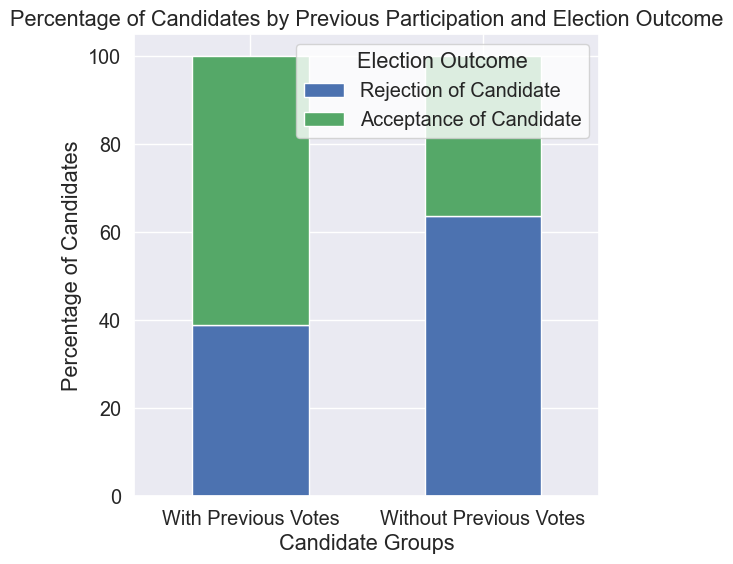

In [140]:
percentage_df = summary_before_adminship_df.groupby(summary_before_adminship_df['TotalNumPrevVotes'].eq(0).map({True: 'Without Previous Votes', False: 'With Previous Votes'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = percentage_df.plot(kind='bar', stacked=True, figsize=(6, 6))

plt.xlabel('Candidate Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by Previous Participation and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
plt.xticks(rotation=0)

plt.show()

In [141]:
percentage_df

RES,0,1
TotalNumPrevVotes,,
With Previous Votes,38.980510,61.019490
Without Previous Votes,63.622211,36.377789


The bar chart reveals a contrast between candidates with prior participation in the voting process and those without. Notably, $61\%$ of candidates with previous engagement were successfully accepted as administrators, whereas only $36\%$ of candidates lacking prior participation received the same outcome.

To validate this observed difference statistically, let's conduct a hypothesis test.

Since we are comparing acceptance rates (a binary outcome) based on a categorical variable (previous participation), a chi-square test for independence is more suitable as it is used when analyzing the association between two categorical variables.

In [142]:
chi2, p, _, _ = chi2_contingency(percentage_df)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 11.186178160495032
P-value: 0.0008240891240052479


At a significance level of $0.05$, the p-value falls below this threshold. Therefore, with $95\%$ confidence, we reject the null hypothesis. This indicates a significant difference in acceptance rates between candidates with and without previous participation in the voting process. However, statistical significance alone doesn't provide a complete understanding of the practical significance or the magnitude of the effect, as the outcome of an election is influenced by many factors that are linked to both the previous activity and the election outcome, and are thus considered as covariates in this study.

So let's dig deeper by evaluating the effect of the previous participation and by considering the covariates about the total number of votes and the percentage of positive and negative votes.

In [144]:
elections_df['WithPrevVotes'] = (summary_before_adminship_df['TotalNumPrevVotes'] > 0).astype(int)
display(elections_df)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,HighNumberOfVotes,HighNeutralPercentage,WithPrevVotes
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00,2013,1,1,1
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00,2013,1,1,1
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00,2013,1,1,0
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00,2013,1,1,1
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00,2013,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,5,5,0,0,100.000000,0.000000,0.000000,2003-10-09 04:54:00,2003-11-09 19:16:00,2003,0,0,0
3924,3925,Ugen64,1,3,3,0,0,100.000000,0.000000,0.000000,2003-12-06 16:05:00,2003-12-06 16:05:00,2003,0,0,0
3925,3926,Vancouverguy,1,3,3,0,0,100.000000,0.000000,0.000000,2003-08-31 02:13:00,2003-09-02 02:51:00,2003,0,0,0
3926,3927,WhisperToMe,1,3,3,0,0,100.000000,0.000000,0.000000,2003-11-26 23:45:00,2003-12-05 05:38:00,2003,0,0,0


To analyze the impact of prior participation in the election process, we match a candidate with previous participation to a candidate without prior engagement who possesses a similar propensity score.

In [145]:
psm = PsmPy(elections_df, treatment='WithPrevVotes', indx='ELECTION_ID', exclude = ['TGT','RES', 'Negative Votes', 'Neutral Votes', 'Positive Votes', 
                                                                                            'Neutral Percentage', 'Earliest Voting Date', 'Latest Voting Date', 'YEA', 'HighNumberOfVotes', 'HighNeutralPercentage'])

psm.logistic_ps(balance = True)

psm.knn_matched(matcher='propensity_score', replacement=False, caliper=None, drop_unmatched=True)

elections_df_balanced_prevtot = psm.df_matched

C:\Users\User\anaconda3\envs\ada\lib\site-packages\psmpy\psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


In [146]:
elections_df_balanced_prevtot = elections_df[elections_df['ELECTION_ID'].isin(elections_df_balanced_prevtot['ELECTION_ID'])]

In [147]:
display(elections_df_balanced_prevtot)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,HighNumberOfVotes,HighNeutralPercentage,WithPrevVotes
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00,2013,1,1,1
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00,2013,1,1,0
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00,2013,1,1,1
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00,2013,1,1,0
5,6,Legoktm,1,156,149,3,4,95.512821,1.923077,2.564103,2013-05-02 03:26:00,2013-05-09 05:33:00,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,5,5,0,0,100.000000,0.000000,0.000000,2003-10-09 04:54:00,2003-11-09 19:16:00,2003,0,0,0
3924,3925,Ugen64,1,3,3,0,0,100.000000,0.000000,0.000000,2003-12-06 16:05:00,2003-12-06 16:05:00,2003,0,0,0
3925,3926,Vancouverguy,1,3,3,0,0,100.000000,0.000000,0.000000,2003-08-31 02:13:00,2003-09-02 02:51:00,2003,0,0,0
3926,3927,WhisperToMe,1,3,3,0,0,100.000000,0.000000,0.000000,2003-11-26 23:45:00,2003-12-05 05:38:00,2003,0,0,0


C:\Users\User\AppData\Local\Temp\ipykernel_14276\4036692606.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\4036692606.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


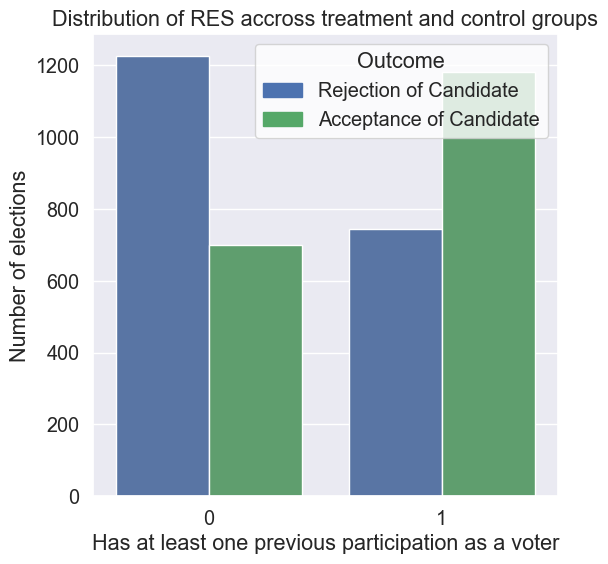

In [148]:
plt.figure(figsize=(6, 6))

sns.countplot(x='WithPrevVotes', hue='RES', data=elections_df_balanced_prevtot)

plt.xlabel('Has at least one previous participation as a voter')
plt.ylabel('Number of elections')
plt.title('Distribution of RES accross treatment and control groups')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

The plot indicates a notable trend: candidates with at least one prior participation as voters exhibit a higher success rate in elections.

To rigorously test this observation, we perform a chi-square test, with the null hypothesis $H_0$ positing no association between previous participation as a voter and election outcomes. 

In [149]:
contingency_table = pd.crosstab(index=elections_df_balanced_prevtot['WithPrevVotes'], columns=elections_df_balanced_prevtot['RES'])

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Value: {chi2}")
print(f"P-value: {p}")

Chi-Square Value: 238.808123727666
P-value: 7.154682952106787e-54


The remarkably small p-value from the test suggests that candidates with at least one previous participation as voters significantly differ in their election outcomes compared to candidates without such participation.

To quantify the influence of the total number of previous votes, let's employ regression analysis.

In [150]:
mod = smf.ols(formula='RES ~ C(WithPrevVotes)', data=elections_df_balanced_prevtot)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    RES   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     255.6
Date:                Thu, 21 Dec 2023   Prob (F-statistic):           9.42e-56
Time:                        22:07:21   Log-Likelihood:                -2671.6
No. Observations:                3853   AIC:                             5347.
Df Residuals:                    3851   BIC:                             5360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.36

After balancing the data in terms of positive percentage and total votes, the regression analysis suggests that candidates who have at least one previous participation as voters have, on average, a higher chance of being elected compared to candidates who don't. Specifically, the mean chance of being elected is $36.3\%$ when the candidate has no previous participation as a voter while it is $61.3\%$ for candidates who previously participated in an election.

Let's now condider the candidates who participated at least once in the previous elections before his request for adminship. Do the number of positive, negative or neutral votes they made or the length of the comments impact the result of their election?

In [151]:
tgt_with_prev_participation = summary_before_adminship_df[summary_before_adminship_df['TotalNumPrevVotes'] > 0]

C:\Users\User\AppData\Local\Temp\ipykernel_14276\1217528814.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\1217528814.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\1217528814.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\1217528814.py:19: MatplotlibDeprecationWarning: The legendHandles attribute

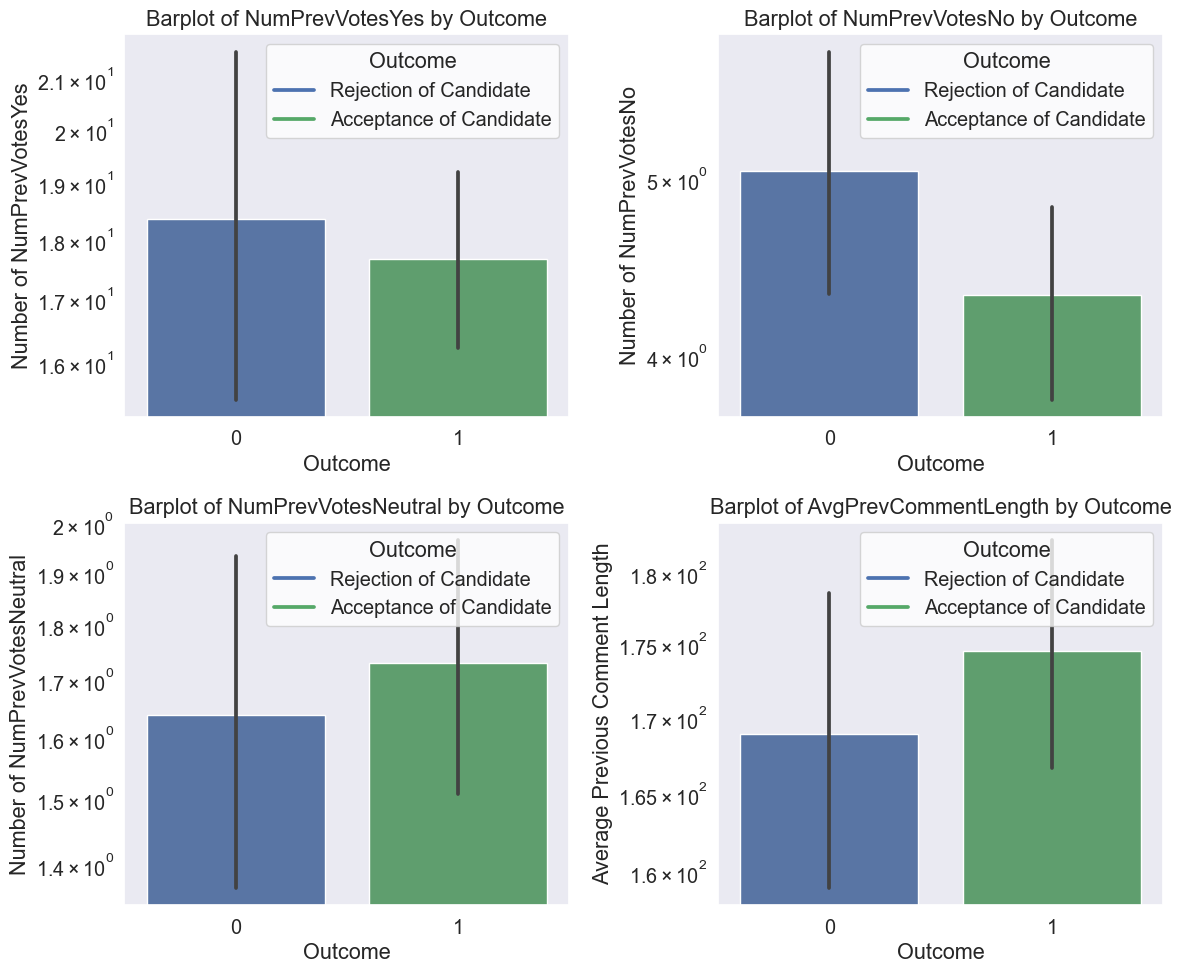

In [152]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Categories to plot
categories = ['NumPrevVotesYes', 'NumPrevVotesNo', 'NumPrevVotesNeutral', 'AvgPrevCommentLength']

for i, category in enumerate(categories):
    row = i // 2
    col = i % 2

    sns.barplot(x='RES', y=category, data=tgt_with_prev_participation, ax=axes[row, col])

    axes[row, col].set_ylabel(f'Number of {category}' if 'NumPrevVotes' in category else 'Average Previous Comment Length')
    axes[row, col].set_xlabel('Outcome')
    axes[row, col].set_title(f'Barplot of {category} by Outcome')
    axes[row, col].set_yscale('log')

    legend = axes[row, col].legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
    legend.legendHandles[0].set_color(sns.color_palette()[0])
    legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.tight_layout()

plt.show()

Upon examining the bar plot for candidates with prior voting experience, it seems that the average number of previous positive, negative, or neutral votes, as well as the average comment length before their candidacy, is consistent regardless of acceptance or rejection.

To validate these observations, let's conduct a t-test to statistically confirm the similarity between accepted and rejected candidates.

In [153]:
t_test_results = {}

for category in categories:
    data_res_0 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 0][category].dropna()
    data_res_1 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 1][category].dropna()

    t_stat, p_value = ttest_ind(data_res_0, data_res_1, alternative='two-sided')

    t_test_results[category] = {'T-statistic': t_stat, 'P-value': p_value}
    
for category, result in t_test_results.items():
    print(f"Category: {category}")
    print(f"T-statistic: {result['T-statistic']}")
    print(f"P-value: {result['P-value']}")
    print()

Category: NumPrevVotesYes
T-statistic: 0.43884699900576585
P-value: 0.6608198290092218

Category: NumPrevVotesNo
T-statistic: 1.5819644296167288
P-value: 0.11381588454628705

Category: NumPrevVotesNeutral
T-statistic: -0.49770651236585023
P-value: 0.6187456606353676

Category: AvgPrevCommentLength
T-statistic: -0.8820169915910627
P-value: 0.37787366238526654



The statistical results reveal no substantial differences in the averages, both for the various categories of votes (positive, neutral, or negative) and the length of comments. This leads to the conclusion that candidates' prior voting behavior and comment length, before aspiring to adminship, may not significantly influence the outcome of their candidacy. 

#### Previous activity as an editor <a id="previous-editor"></a>

We now study the influence of the previous revisions a candidate has done.

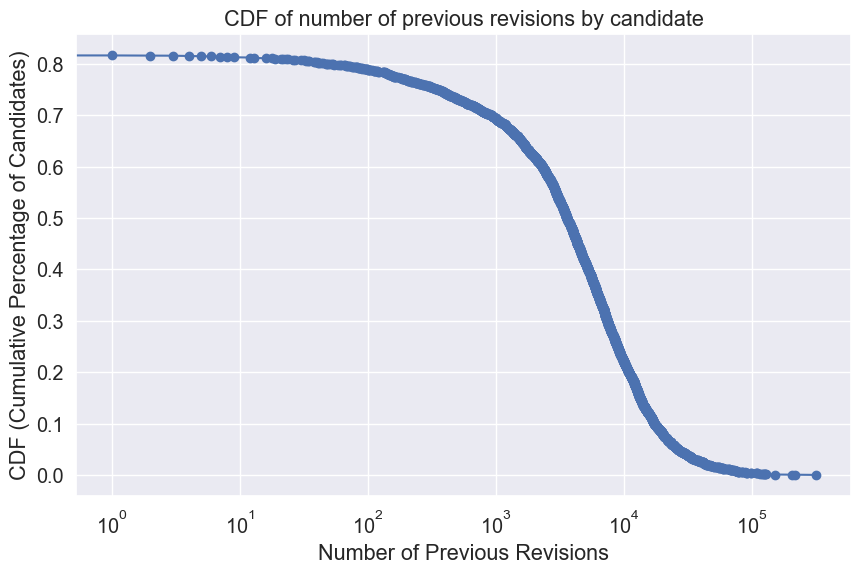

In [161]:
cdf = 1 - summary_before_adminship_df['NumPrevRevisions'].value_counts().sort_index().cumsum() / len(summary_before_adminship_df['NumPrevRevisions']) 

plt.figure(figsize=(10, 6))
plt.plot(cdf.index, cdf, marker='o', linestyle='-')
plt.xlabel('Number of Previous Revisions')
plt.ylabel('CDF (Cumulative Percentage of Candidates)')
plt.title('CDF of number of previous revisions by candidate')
plt.xscale('log')
plt.grid(True)
plt.show()

We can notice from the graph above, that $81\%$ of the candidates had previously done revisions on a wiki page before their candidacy, with a half of them having done more than $3500$ revisions before running for adminship.

Let's categorize candidates in two groups with the variable `WithPrevRev` that indicate if the candidate had done any revisions before running for adminship.

In [165]:
elections_df['WithPrevRev'] = (summary_before_adminship_df['NumPrevRevisions'] > 0.0).astype(int)
display(elections_df)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date,YEA,HighNumberOfVotes,HighNeutralPercentage,WithPrevVotes,WithPrevRev
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00,2013,1,1,1,1
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00,2013,1,1,1,1
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00,2013,1,1,0,1
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00,2013,1,1,1,1
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00,2013,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,5,5,0,0,100.000000,0.000000,0.000000,2003-10-09 04:54:00,2003-11-09 19:16:00,2003,0,0,0,1
3924,3925,Ugen64,1,3,3,0,0,100.000000,0.000000,0.000000,2003-12-06 16:05:00,2003-12-06 16:05:00,2003,0,0,0,1
3925,3926,Vancouverguy,1,3,3,0,0,100.000000,0.000000,0.000000,2003-08-31 02:13:00,2003-09-02 02:51:00,2003,0,0,0,1
3926,3927,WhisperToMe,1,3,3,0,0,100.000000,0.000000,0.000000,2003-11-26 23:45:00,2003-12-05 05:38:00,2003,0,0,0,1


C:\Users\User\AppData\Local\Temp\ipykernel_14276\2897835752.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\User\AppData\Local\Temp\ipykernel_14276\2897835752.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


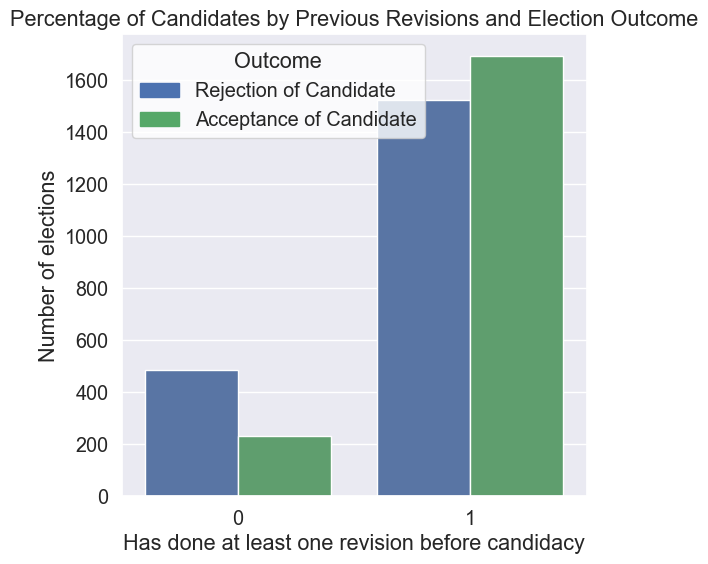

In [166]:
plt.figure(figsize=(6, 6))

sns.countplot(x='WithPrevRev', hue='RES', data=elections_df)

plt.xlabel('Has done at least one revision before candidacy')
plt.ylabel('Number of elections')
plt.title('Percentage of Candidates by Previous Revisions and Election Outcome')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'], facecolor='white', frameon=True)
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

In [167]:
percentage_df = elections_df.groupby(elections_df['WithPrevRev'].eq(0).map({True: 'Without Previous Revisions', False: 'With Previous Revisions'}))['RES'].value_counts(normalize=True).unstack() * 100
percentage_df

RES,0,1
WithPrevRev,,
With Previous Revisions,47.353674,52.646326
Without Previous Revisions,67.737430,32.262570


As previously observed, a small number of candidates did not contribute any revisions to wiki pages before running for adminship. However, the insights from the plot above reveal that having prior revisions does not significantly influence the election outcome. However, for candidates without any prior revisions, a noteworthy trend emerges. A substantial proportion of them face rejection, with only $32.3\%$ experiencing a successful election.

Let's perform hypothesis test to confirm our assumption.

First, we consider the following null hypothesis : the probability of being accepted is equal to the probability of being rejected within the group of candidates with previous revisions. The alternative hypothesis is that they are not equal. 

In [173]:
candidates_with_prev_revisions = elections_df[elections_df['WithPrevRev'] == 1]

accepted_candidates = candidates_with_prev_revisions[candidates_with_prev_revisions['RES'] == 1].shape[0]
rejected_candidates = candidates_with_prev_revisions[candidates_with_prev_revisions['RES'] == 0].shape[0]

total_candidates = len(candidates_with_prev_revisions)

stat, p_value = proportions_ztest(accepted_candidates, total_candidates, value=0.5, alternative='larger')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The probabilities of being accepted and rejected within the group of candidates with previous revisions are significantly different.")
else:
    print("There is no significant difference in the probabilities of being accepted and rejected within the group of candidates with previous revisions.")

Z-statistic: 3.0038
P-value: 0.0013
The probabilities of being accepted and rejected within the group of candidates with previous revisions are significantly different.


While the numerical breakdown shows that $47.4\%$ of candidates were rejected compared to $52.6\%$ who were accepted among those with previous edit revisions, the statistical test indicates a significant difference between the numbers of accepted and rejected candidates. Despite the appearance of a balanced outcome, the test provides evidence for a meaningful distinction within this group.

We now consider the following null hypothesis : the probability of being accepted is equal to the probability of being rejected within the group of candidates with no previous revisions. The alternative hypothesis is that there is a more probability to be rejected than being accepted within this group of candidates.

In [174]:
candidates_with_noprev_revisions = elections_df[elections_df['WithPrevRev'] == 0]

accepted_candidates = candidates_with_noprev_revisions[candidates_with_noprev_revisions['RES'] == 1].shape[0]
rejected_candidates = candidates_with_noprev_revisions[candidates_with_noprev_revisions['RES'] == 0].shape[0]

total_candidates = len(candidates_with_noprev_revisions)

stat, p_value = proportions_ztest(accepted_candidates, total_candidates, value=0.5, alternative='smaller')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The probabilities of being accepted and rejected for candidates with no previous revisions are significantly different.")
else:
    print("There is no significant difference in the probabilities of being accepted and rejected for candidates with no previous revisions.")

Z-statistic: -10.1527
P-value: 0.0000
The probabilities of being accepted and rejected for candidates with no previous revisions are significantly different.


Our assumption for candidates with no previous revisions is supported by the statistical test above, suggesting a higher probability of rejection than acceptance for candidates without any edit revisions.

## Conclusion <a id="conclusion"></a>

Our data exploration shows that several factors contribute to a candidate's potential for a successful election. While surpassing the 75% threshold for the percentage of positive votes, as indicated in the Wikipedia guide, is crucial, we've identified additional factors that can bolster a candidacy. These factors can be categorized into two groups:

- Factors Directly Influenced by the Candidate : previous participation as a voter in the voting process as well as a history of edits and revisions. These two factors increasing the chances of election through a well-engaged profile. This aspect appear to resonate positively with voters.
- Factors Indirectly Influenced by the Candidate : the number of voters participating in the election and the percentage of neutral votes the candidate receives. These factors depend more on voters' choices, but we've observed a statistical influence on the election outcome. 

Although, all of these factors don't depend entirely on the candidate, he is able to influence them by developing the right skills (refer to the NLP notebook) or creating affinity with a Wikipedia community sharing the same interests (refer to graph analysis notebook).